In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime
import seaborn as sns
import pydicom
import time
import gc
import operator 
from apex import amp 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
from sklearn.model_selection import KFold
from tqdm import tqdm, tqdm_notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings(action='once')
import pickle
%load_ext autoreload
%autoreload 2
#%matplotlib inline
from skimage.io import imread,imshow
from helper import *
from apex import amp
import helper
import torchvision.models as models
from torch.optim import Adam
from defenitions import *

/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
SEED = 4356
#device=device_by_name("Tesla")
device=device_by_name("RTX")
#device = "cpu"

In [3]:
train_df = pd.read_csv(data_dir+'train.csv')
train_df=train_df[~train_df.PatientID.isin(bad_images)].reset_index(drop=True)
train_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,63eb1e259,0,0,0,0,0,0,a449357f,62d125e5b2,0be5c0d1b3,"['00036', '00036']","['00080', '00080']",180.199951,-125.0,-8.000000
1,2669954a7,0,0,0,0,0,0,363d5865,a20b80c7bf,3564d584db,"['00047', '00047']","['00080', '00080']",922.530821,-156.0,45.572849
2,52c9913b1,0,0,0,0,0,0,9c2b4bd7,3e3634f8cf,973274ffc9,40,150,4.455000,-125.0,-115.063000
3,4e6ff6126,0,0,0,0,0,0,3ae81c2d,a1390c15c2,e5ccad8244,"['00036', '00036']","['00080', '00080']",100.000000,-99.5,28.500000
4,7858edd88,0,0,0,0,0,0,c1867feb,c73e81ed3a,28e0531b3a,40,100,145.793000,-125.0,-132.190000


In [4]:
split = train_df.SeriesI.unique()
np.random.seed(SEED)
np.random.shuffle(split)
split_train=split[:int(0.9*split.shape[0])]
split_val=split[int(0.9*split.shape[0]):]

idx_train = train_df[train_df.SeriesI.isin(set(split_train))].index.values
idx_validate = train_df[train_df.SeriesI.isin(set(split_val))].index.values
idx_train.shape
idx_validate.shape

(606796,)

(67708,)

In [5]:
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)

In [6]:
test_df = pd.read_csv(data_dir+'test.csv')
test_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,SeriesI,PID,StudyI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,28fbab7eb,0.5,0.5,0.5,0.5,0.5,0.5,ebfd7e4506,cf1b6b11,93407cadbb,30,80,158.458000,-125.0,-135.598000
1,877923b8b,0.5,0.5,0.5,0.5,0.5,0.5,6d95084e15,ad8ea58f,a337baa067,30,80,138.729050,-125.0,-101.797981
2,a591477cb,0.5,0.5,0.5,0.5,0.5,0.5,8e06b2c9e0,ecfb278b,0cfe838d54,30,80,60.830002,-125.0,-133.300003
3,42217c898,0.5,0.5,0.5,0.5,0.5,0.5,e800f419cf,e96e31f4,c497ac5bad,30,80,55.388000,-125.0,-146.081000
4,a130c4d2f,0.5,0.5,0.5,0.5,0.5,0.5,faeb7454f3,69affa42,854e4fbc01,30,80,33.516888,-125.0,-118.689819


In [7]:
def get_submission(test_df,pred):
    epidural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_epidural','Label':torch.sigmoid(pred[:,0])})
    intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraparenchymal','Label':torch.sigmoid(pred[:,1])})
    intraventricular_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraventricular','Label':torch.sigmoid(pred[:,2])})
    subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subarachnoid','Label':torch.sigmoid(pred[:,3])})
    subdural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subdural','Label':torch.sigmoid(pred[:,4])})
    any_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_any','Label':torch.sigmoid(pred[:,5])}) 
    return pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).sort_values('ID').reset_index(drop=True)

In [8]:
def my_loss(y_pred,y_true,weights):
    return F.binary_cross_entropy_with_logits(y_pred,y_true,weights.repeat(y_pred.shape[0],1))

In [9]:
def get_optimizer_parameters(model,klr):
    zero_layer=['conv0','norm0']
    param_optimizer = list(model.named_parameters())
    num_blocks=4
    no_decay=['bias']
    optimizer_grouped_parameters=[
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and any(nd in n for nd in zero_layer))], 'lr':klr*2e-5,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and any(nd in n for nd in zero_layer)], 'lr':klr*2e-5, 'weight_decay': 0.0}
        ]
    optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('classifier' in n))], 'lr':klr*1e-3,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('classifier' in n)], 'lr':klr*1e-3, 'weight_decay': 0.0}
        ])
    optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('wso' in n))], 'lr':klr*5e-5,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('wso' in n)], 'lr':klr*5e-5, 'weight_decay': 0.0}
        ])
    for i in range(num_blocks):
        optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('denseblock{}'.format(i+1) in n))], 'lr':klr*(2.0**i)*2e-5,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('denseblock{}'.format(i+1) in n)], 'lr':klr*(2.0**i)*2e-5, 'weight_decay': 0.0}
        ])
    optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('norm5' in n))], 'lr':klr*1e-4,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('norm5' in n)], 'lr':klr*1e-4, 'weight_decay': 0.0}
        ])
    return(optimizer_grouped_parameters)

    

In [10]:
class parameter_scheduler():
    def __init__(self,model,do_first=['classifier'],num_epoch=1):
        self.model=model
        self.do_first = do_first
        self.num_epoch=num_epoch
    def __call__(self,epoch):
        if epoch>=self.num_epoch:
            for n,p in self.model.named_parameters():
                p.requires_grad=True
        else:
            for n,p in self.model.named_parameters():
                p.requires_grad= any(nd in n for nd in self.do_first)


<IPython.core.display.Javascript object>


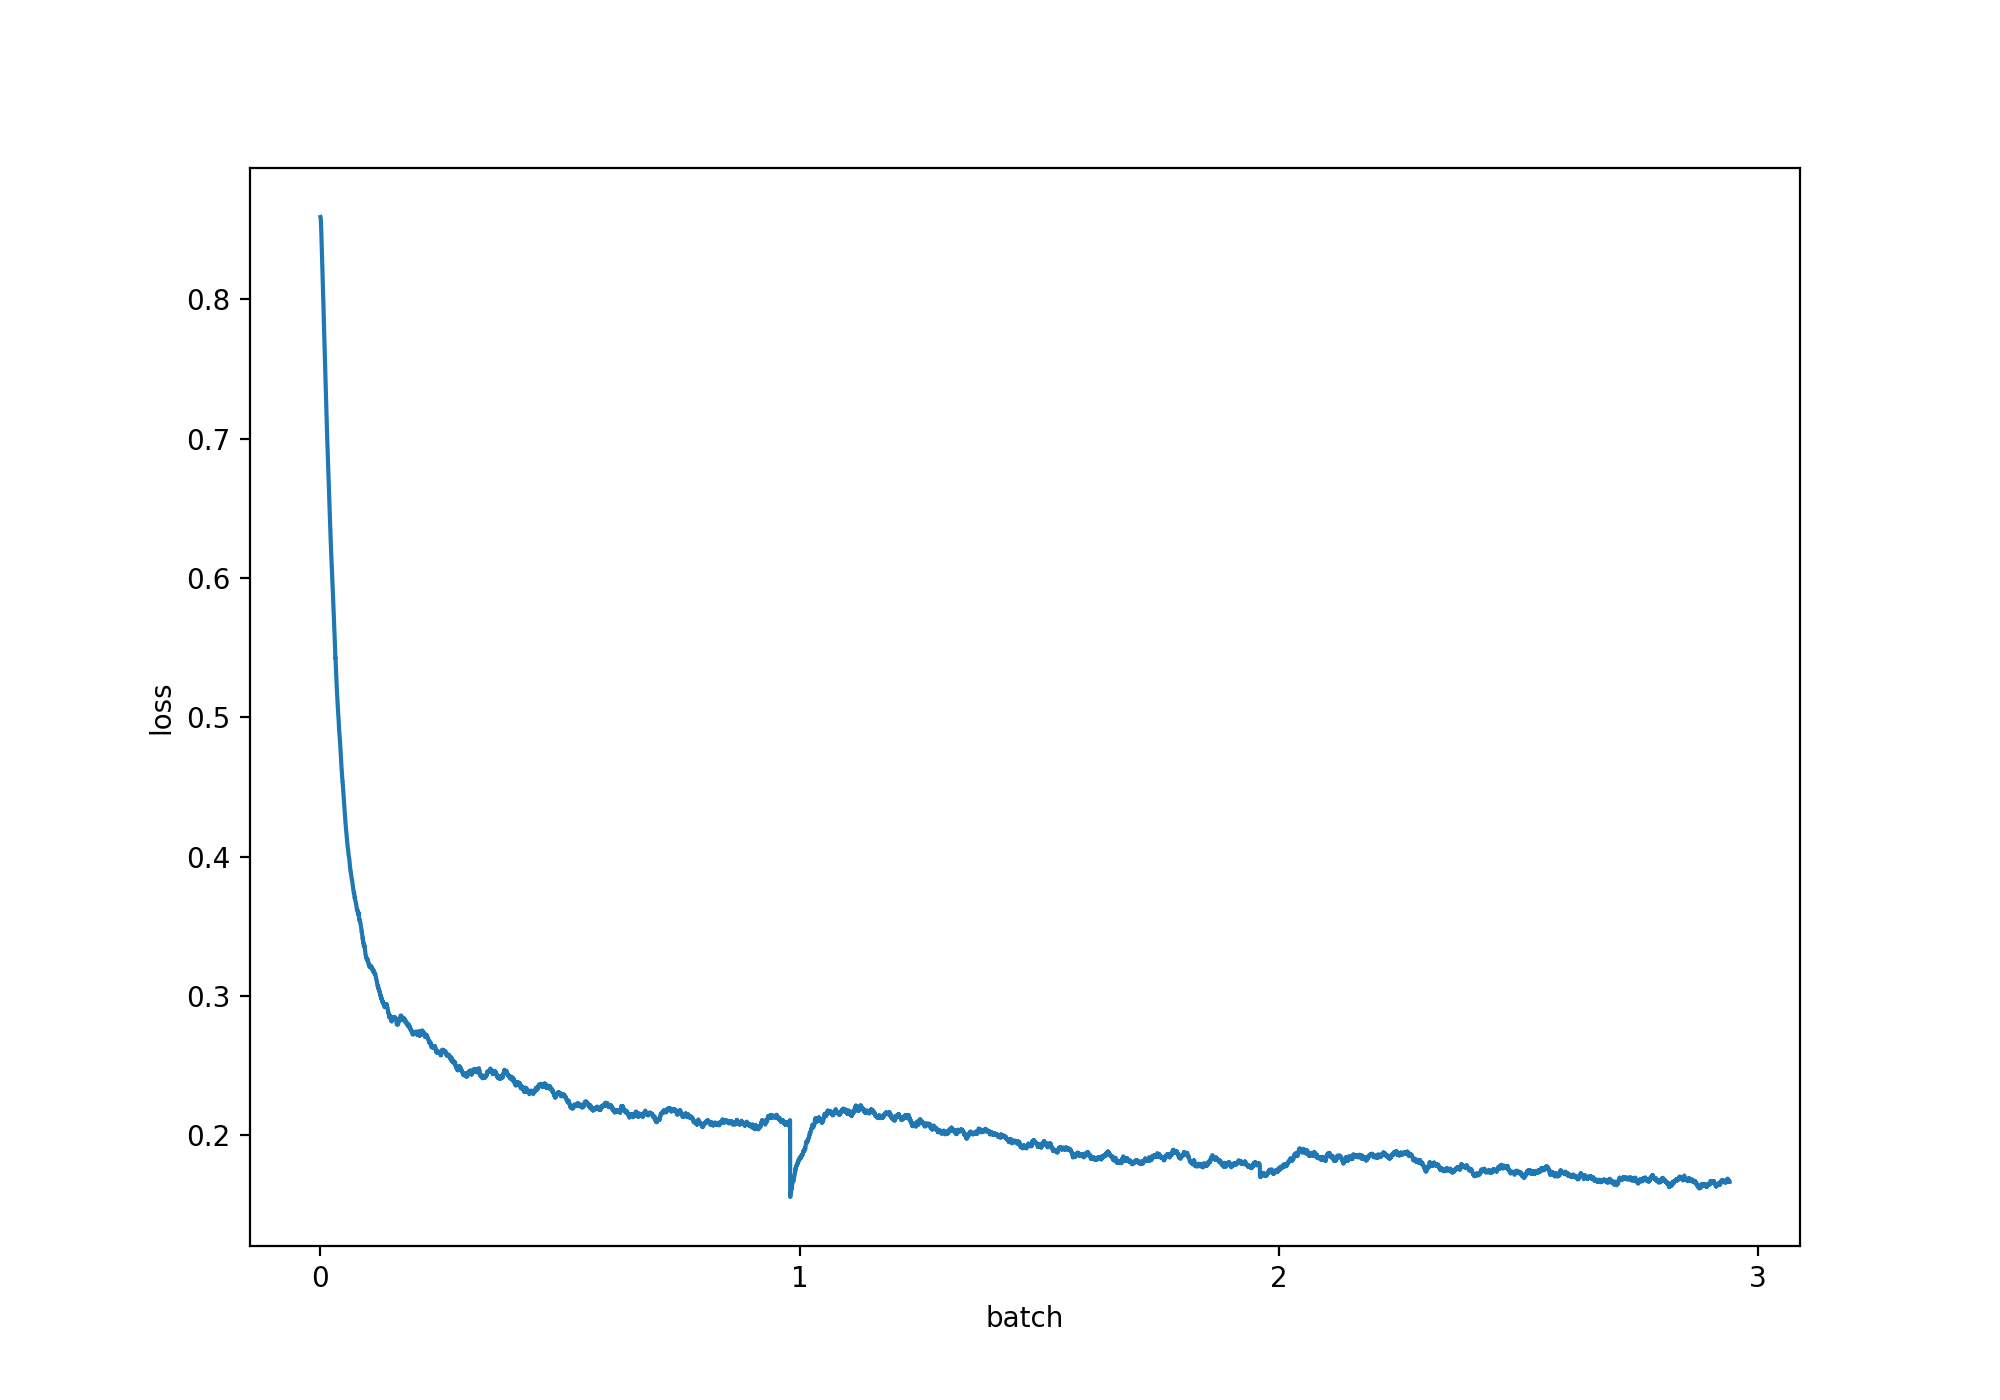

{'loss': 0.210439175986185, 'val_loss': 0.11076023830329763}


{'loss': 0.17871577242581482, 'val_loss': 0.11439628208615941}


{'loss': 0.16660044339895608, 'val_loss': 0.10995706401955484}
0.10995706401955484


In [12]:
%matplotlib nbagg

num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=12
num_epochs=3
model_name,version = 'Densenet121_3' , 'basic'
model = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types),num_channels=3)
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=512,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,
                           window_eq=3,equalize=True)
transform_val=MyTransform(out_size=512)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,
                               window_eq=3,equalize=True)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=1)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,int(num_train_optimization_steps/num_epochs)+1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=sampling,
                                graph=gr)


In [13]:
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [14]:
torch.save(model.state_dict(), models_dir+models_format.format(model_name,version+'model',num_split))

<IPython.core.display.Javascript object>


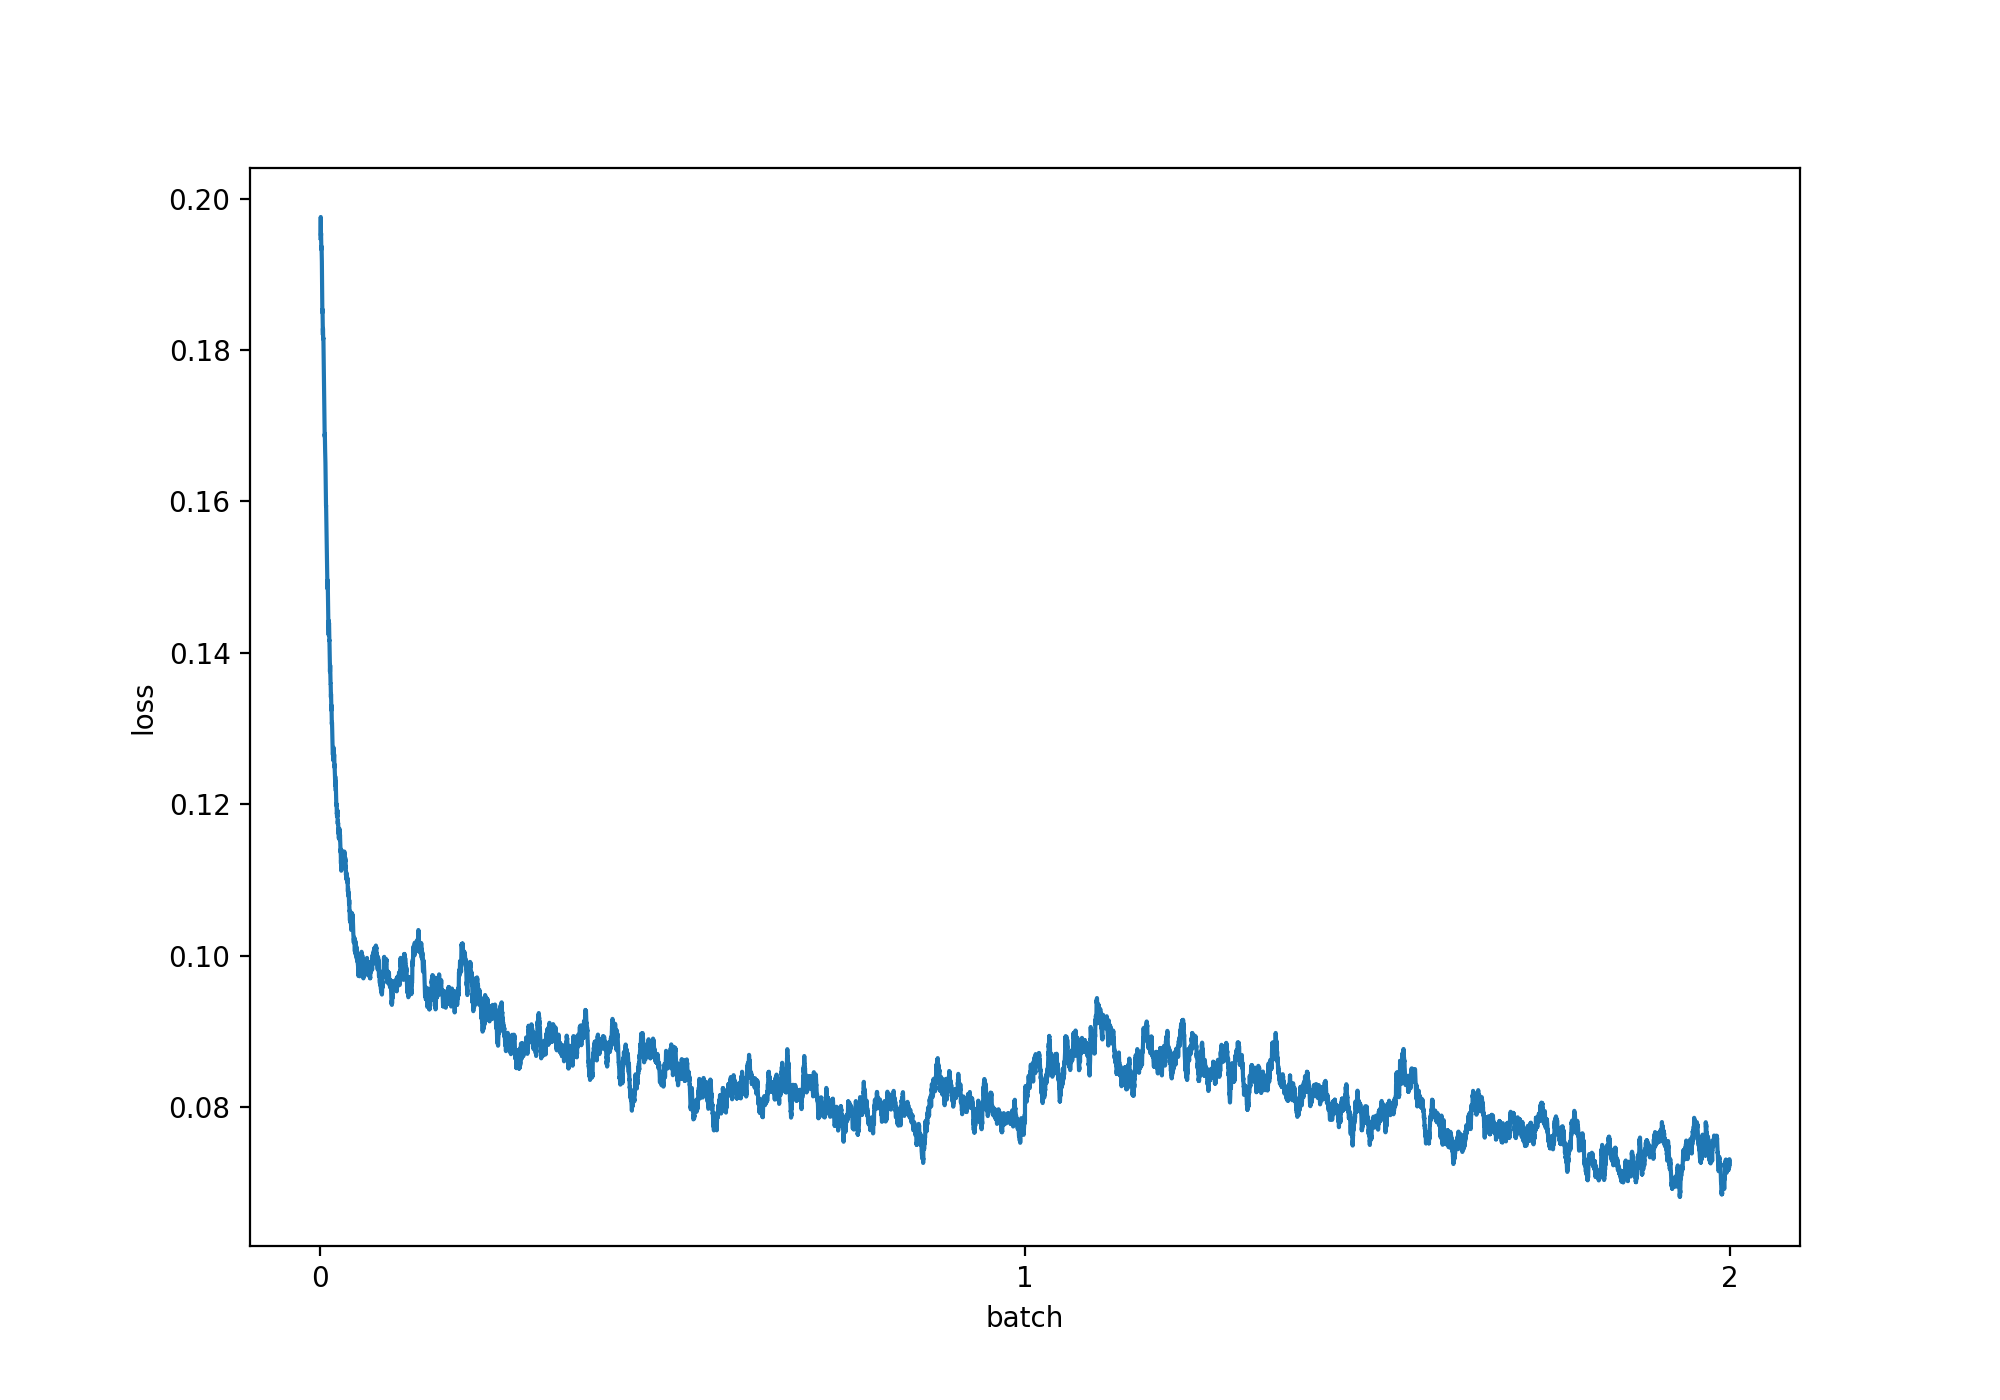

{'loss': 0.07815260775086168, 'val_loss': 0.08489519673521104}


{'loss': 0.07249027544849285, 'val_loss': 0.08444632365260914}
0.08444632365260914


In [16]:
%matplotlib nbagg


num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=12
num_epochs=2
model_name,version = 'Densenet121_3' , 'basic_classifier'
model = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types),num_channels=3)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic',num_split),map_location=torch.device(device)))
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=512,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,
                           window_eq=3,equalize=True)
transform_val=MyTransform(out_size=512)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,
                               window_eq=3,equalize=True)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,int(num_train_optimization_steps/num_epochs)+1)
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

/home/reina/anaconda3/envs/RSNA/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


<IPython.core.display.Javascript object>


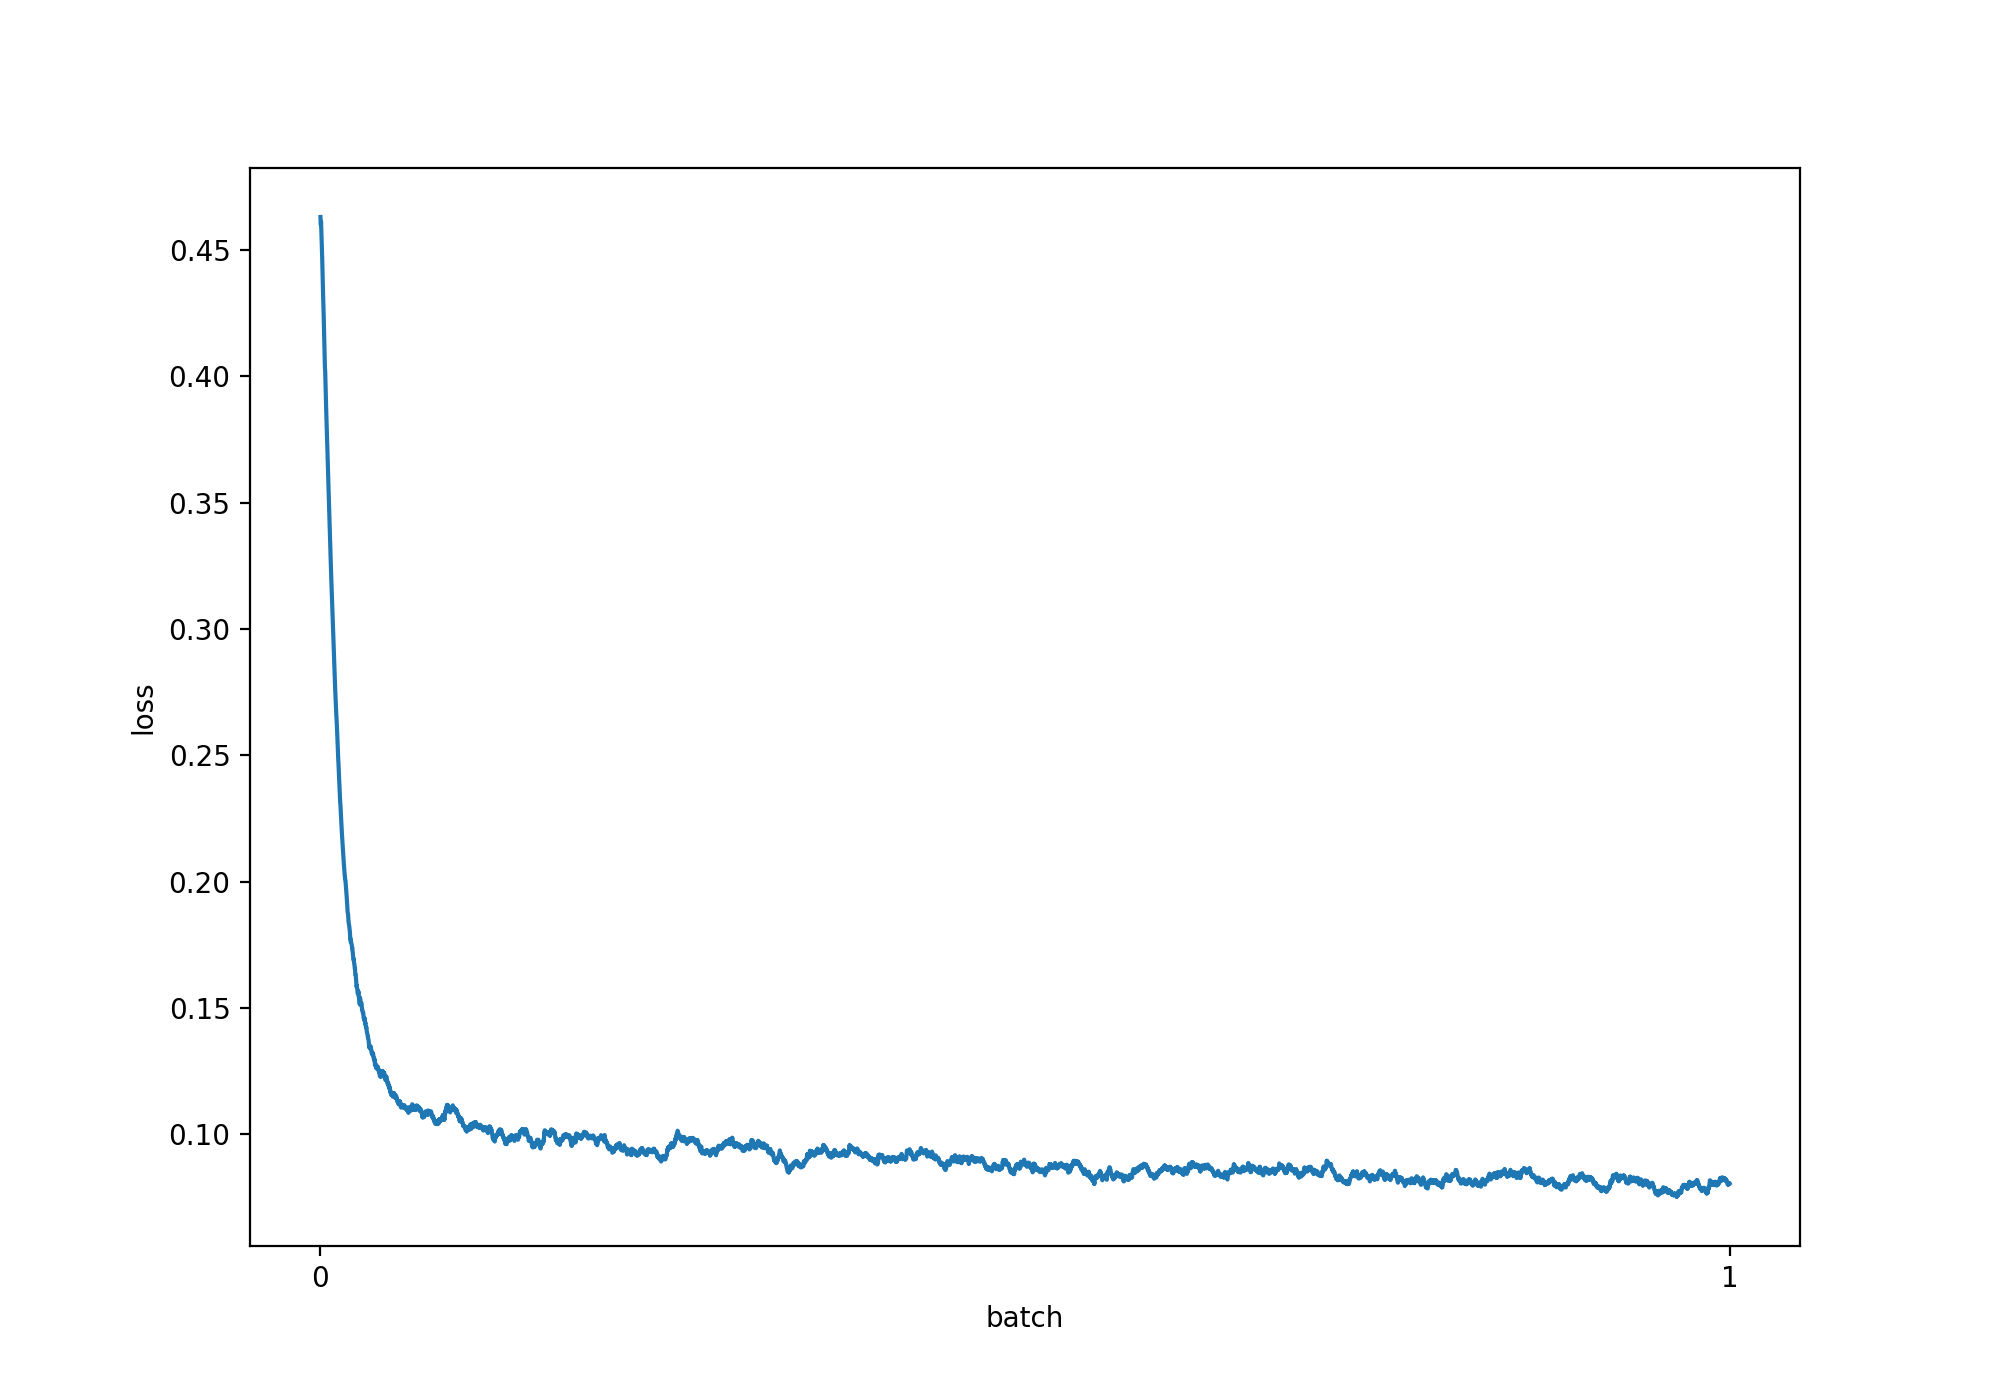

{'loss': 0.08054732726179217, 'val_loss': 0.08693184752179228}

0.08693184752179228


In [11]:
%matplotlib nbagg


num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=12
num_epochs=1
model_name,version = 'Densenet121_3' , 'basic_classifier_wso'
model0 = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types),num_channels=3)
model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic_classifier',num_split),map_location=torch.device(device)))
model = MyDenseNet(model0,len(hemorrhage_types),strategy=None,num_channels=3,wso=True)
_=model.classifier.weight.data.copy_(model0.classifier.weight.data)
_=model.classifier.bias.data.copy_(model0.classifier.bias.data)
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=512,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,
                           window_eq=False,equalize=False)
transform_val=MyTransform(out_size=512)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,
                               window_eq=False,equalize=False)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,int(num_train_optimization_steps/num_epochs)+1)
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

/home/reina/anaconda3/envs/RSNA/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


<IPython.core.display.Javascript object>


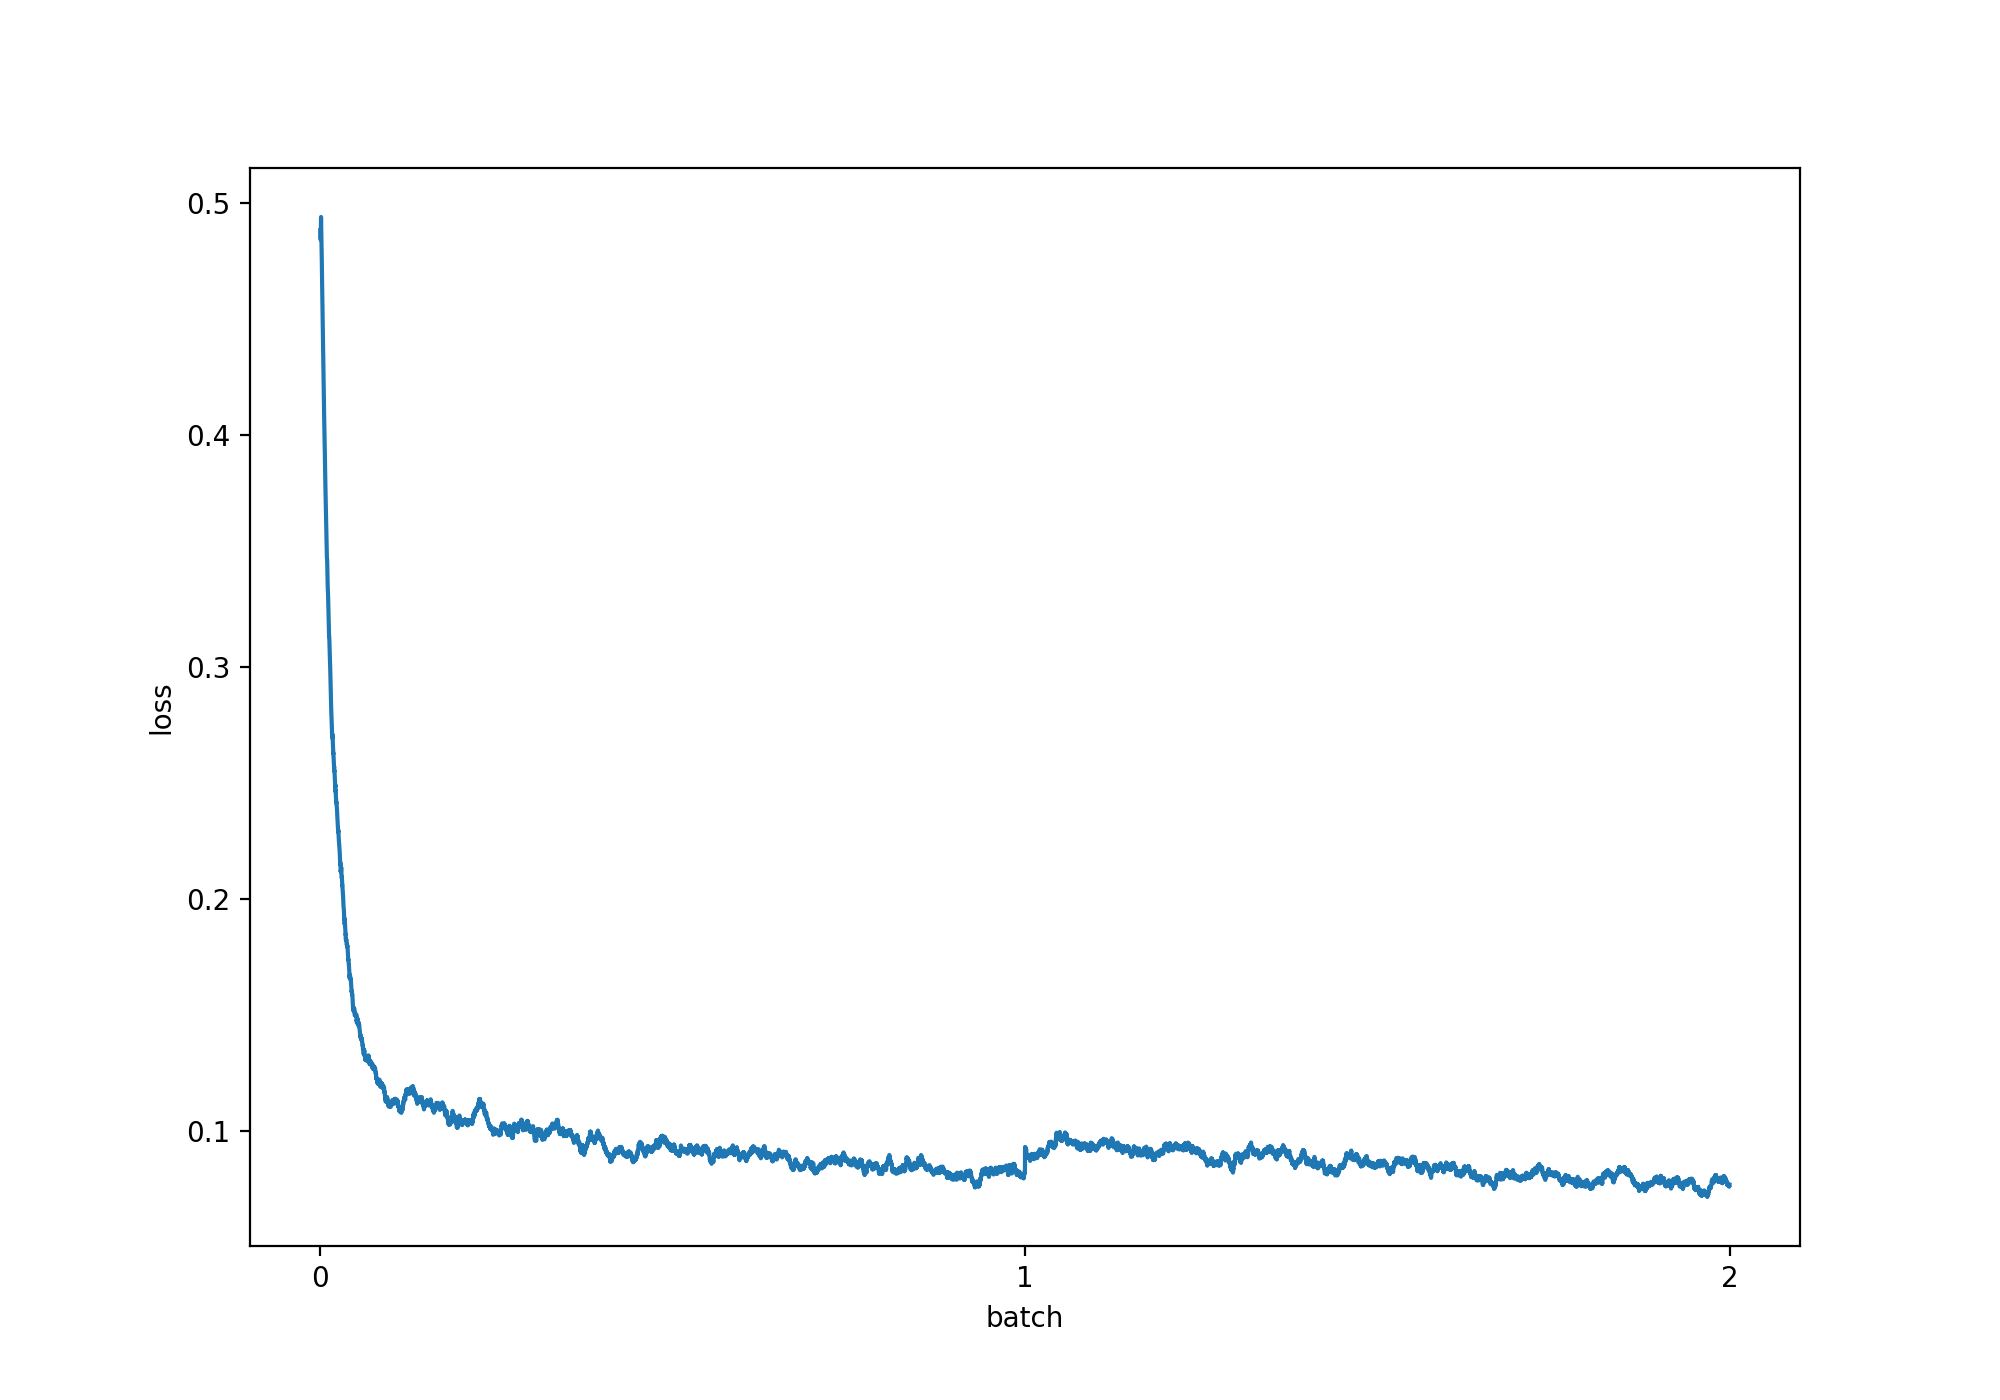

{'loss': 0.0832270085296224, 'val_loss': 0.08830680072462514}


{'loss': 0.07701185103461956, 'val_loss': 0.08638749891867428}

0.08638749891867428


In [11]:
%matplotlib nbagg


num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=12
num_epochs=2
model_name,version = 'Densenet121_3' , 'basic_classifier_wso'
model0 = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types),num_channels=3)
model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic_classifier',num_split),map_location=torch.device(device)))
model = MyDenseNet(model0,len(hemorrhage_types),strategy=None,num_channels=3,wso=True)
_=model.classifier.weight.data.copy_(model0.classifier.weight.data)
_=model.classifier.bias.data.copy_(model0.classifier.bias.data)
_=model.features.wso_conv.weight.data.copy_(torch.tensor([[[[1/20.0]]],[[[1/100.0]]],[[[1/1400.0]]]]))
_=model.features.wso_conv.bias.data.copy_(torch.tensor([ 0.0, 0.05, -0.03]))
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=512,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,
                           window_eq=False,equalize=False,rescale=True)
transform_val=MyTransform(out_size=512)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,
                               window_eq=False,equalize=False,rescale=True)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,int(num_train_optimization_steps/num_epochs)+1)
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [12]:
history

[{'loss': 0.0832270085296224, 'val_loss': 0.08830680072462514},
 {'loss': 0.07701185103461956, 'val_loss': 0.08638749891867428}]

In [12]:
model_name,version,num_split = 'Densenet121_3' , 'basic_classifier',0
model = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types),return_features=True,num_channels=3)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model.to(device)
transform_val=MyTransform(out_size=512)
train_dataset=D.Subset(ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,
                          window_eq=3,equalize=True))
pred,features = model_run(model,train_dataset,do_apex=True,batch_size=32,num_workers=16)

pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train',num_split),'wb')
pickle.dump(features,pickle_file,protocol=4)
pickle_file.close()
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'predictions_train',num_split),'wb')
pickle.dump(features,pickle_file,protocol=4)
pickle_file.close()

my_loss(pred[idx_validate],
        torch.tensor(train_df[hemorrhage_types].values[idx_validate],dtype=torch.float),
        torch.tensor([1.,1.,1.,1.,1.,2.]))

tensor(0.0844)

/home/reina/anaconda3/envs/RSNA/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


<IPython.core.display.Javascript object>


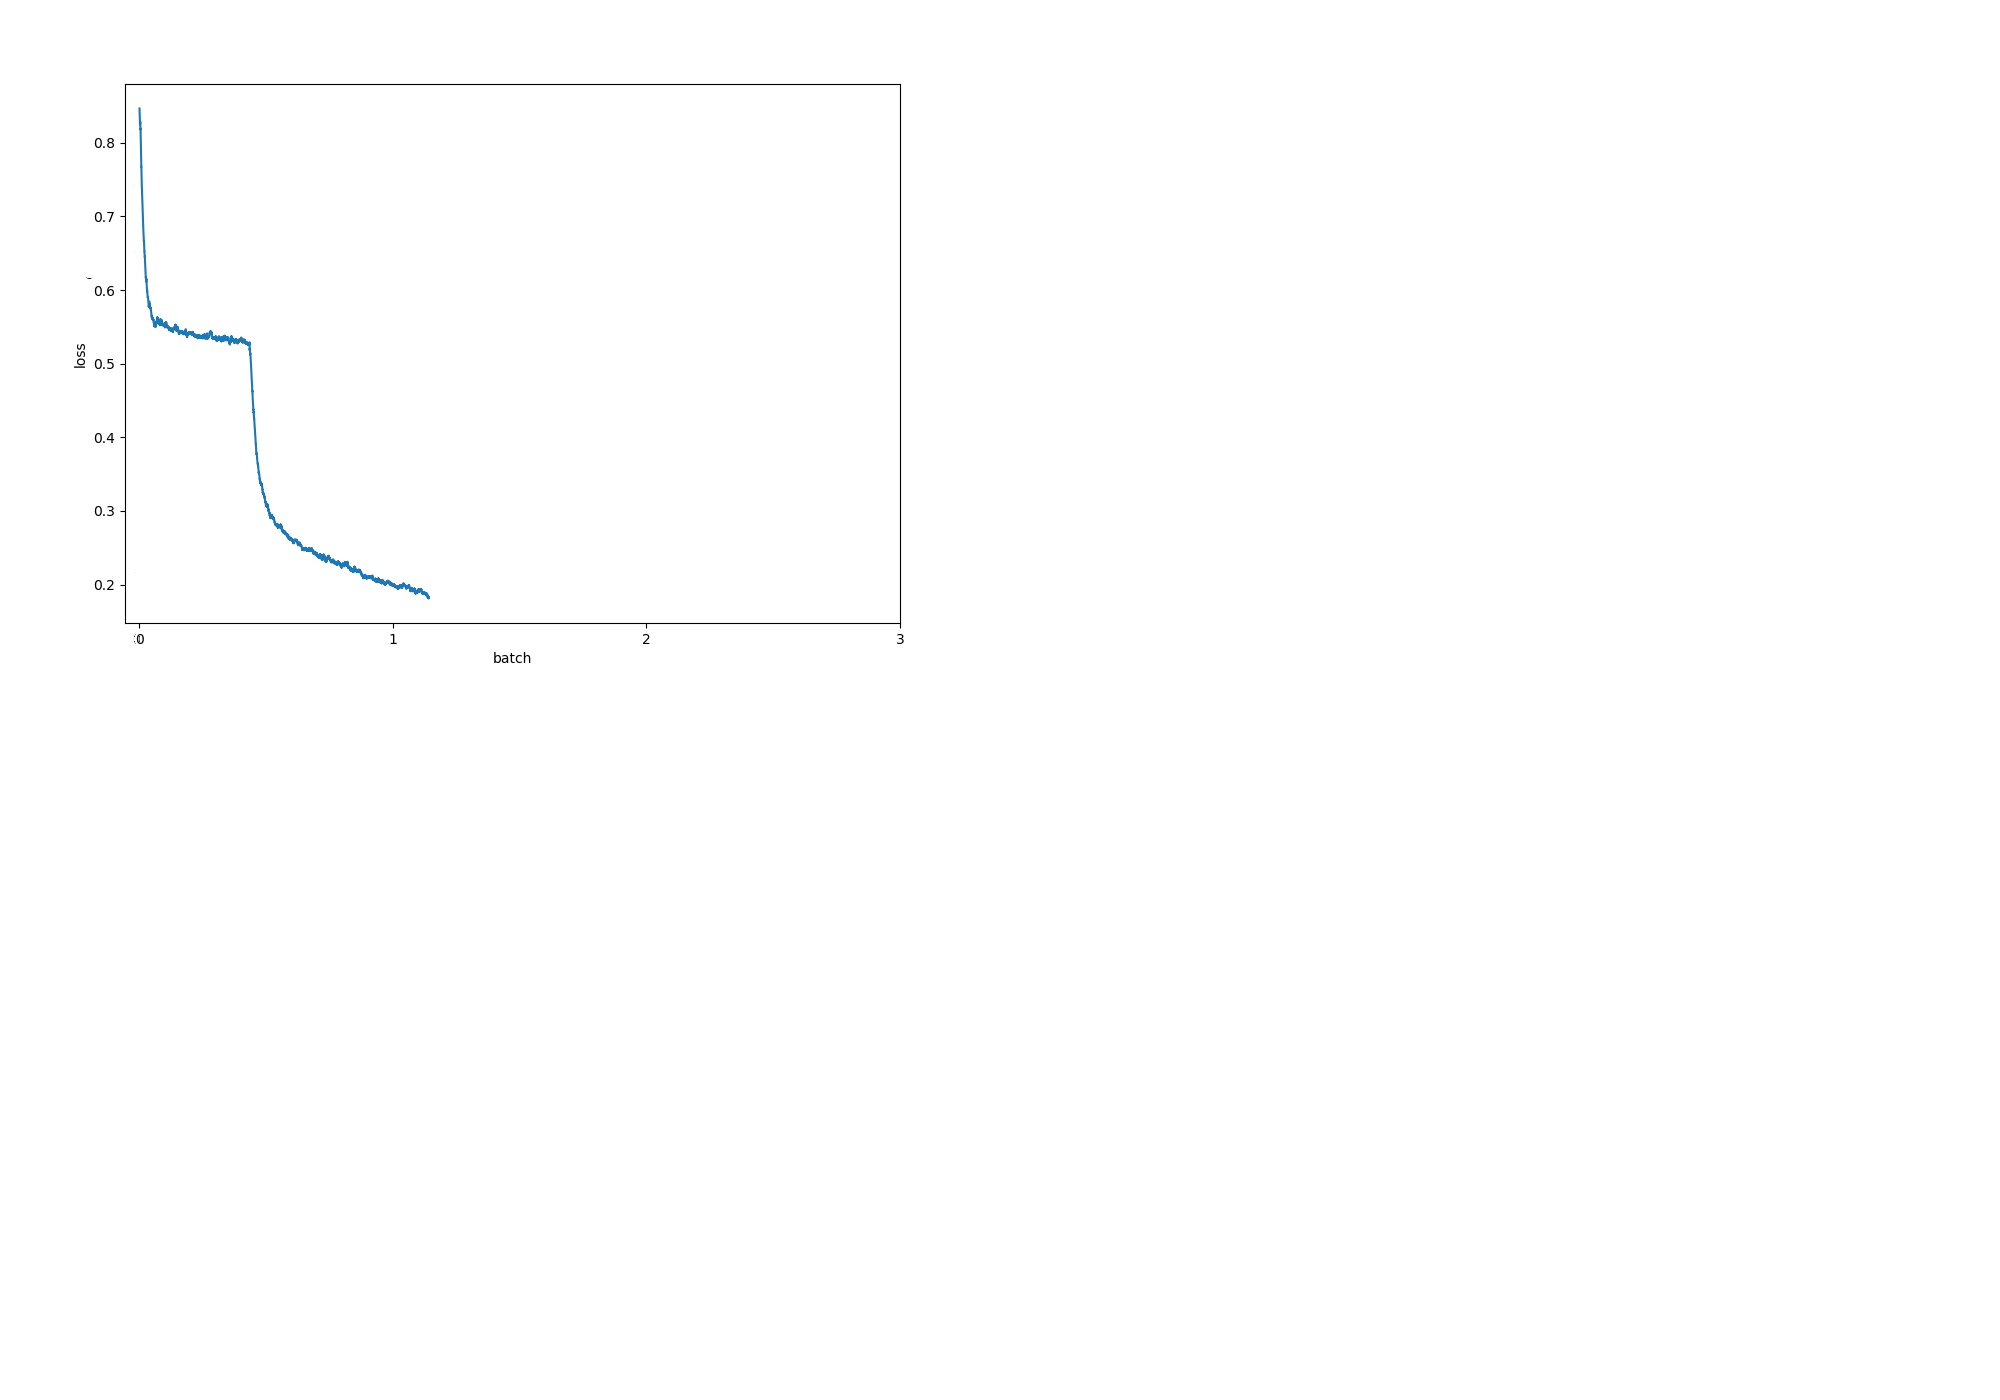

{'loss': 0.5287968136202618, 'val_loss': 0.3574927407255245}


{'loss': 0.21785892410177857, 'val_loss': 0.12921778002792586}


KeyboardInterrupt: 

In [11]:
%matplotlib nbagg


num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=64
num_workers=12
num_epochs=3
model_name,version = 'Densenet121' , 'basic3'
model = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,
                            base_path=train_images_dir,window_eq=True,equalize=False)
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,
                                base_path=train_images_dir,window_eq=True,equalize=False)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//3,tau=1)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=model.parameter_scheduler,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=sampling,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

<IPython.core.display.Javascript object>


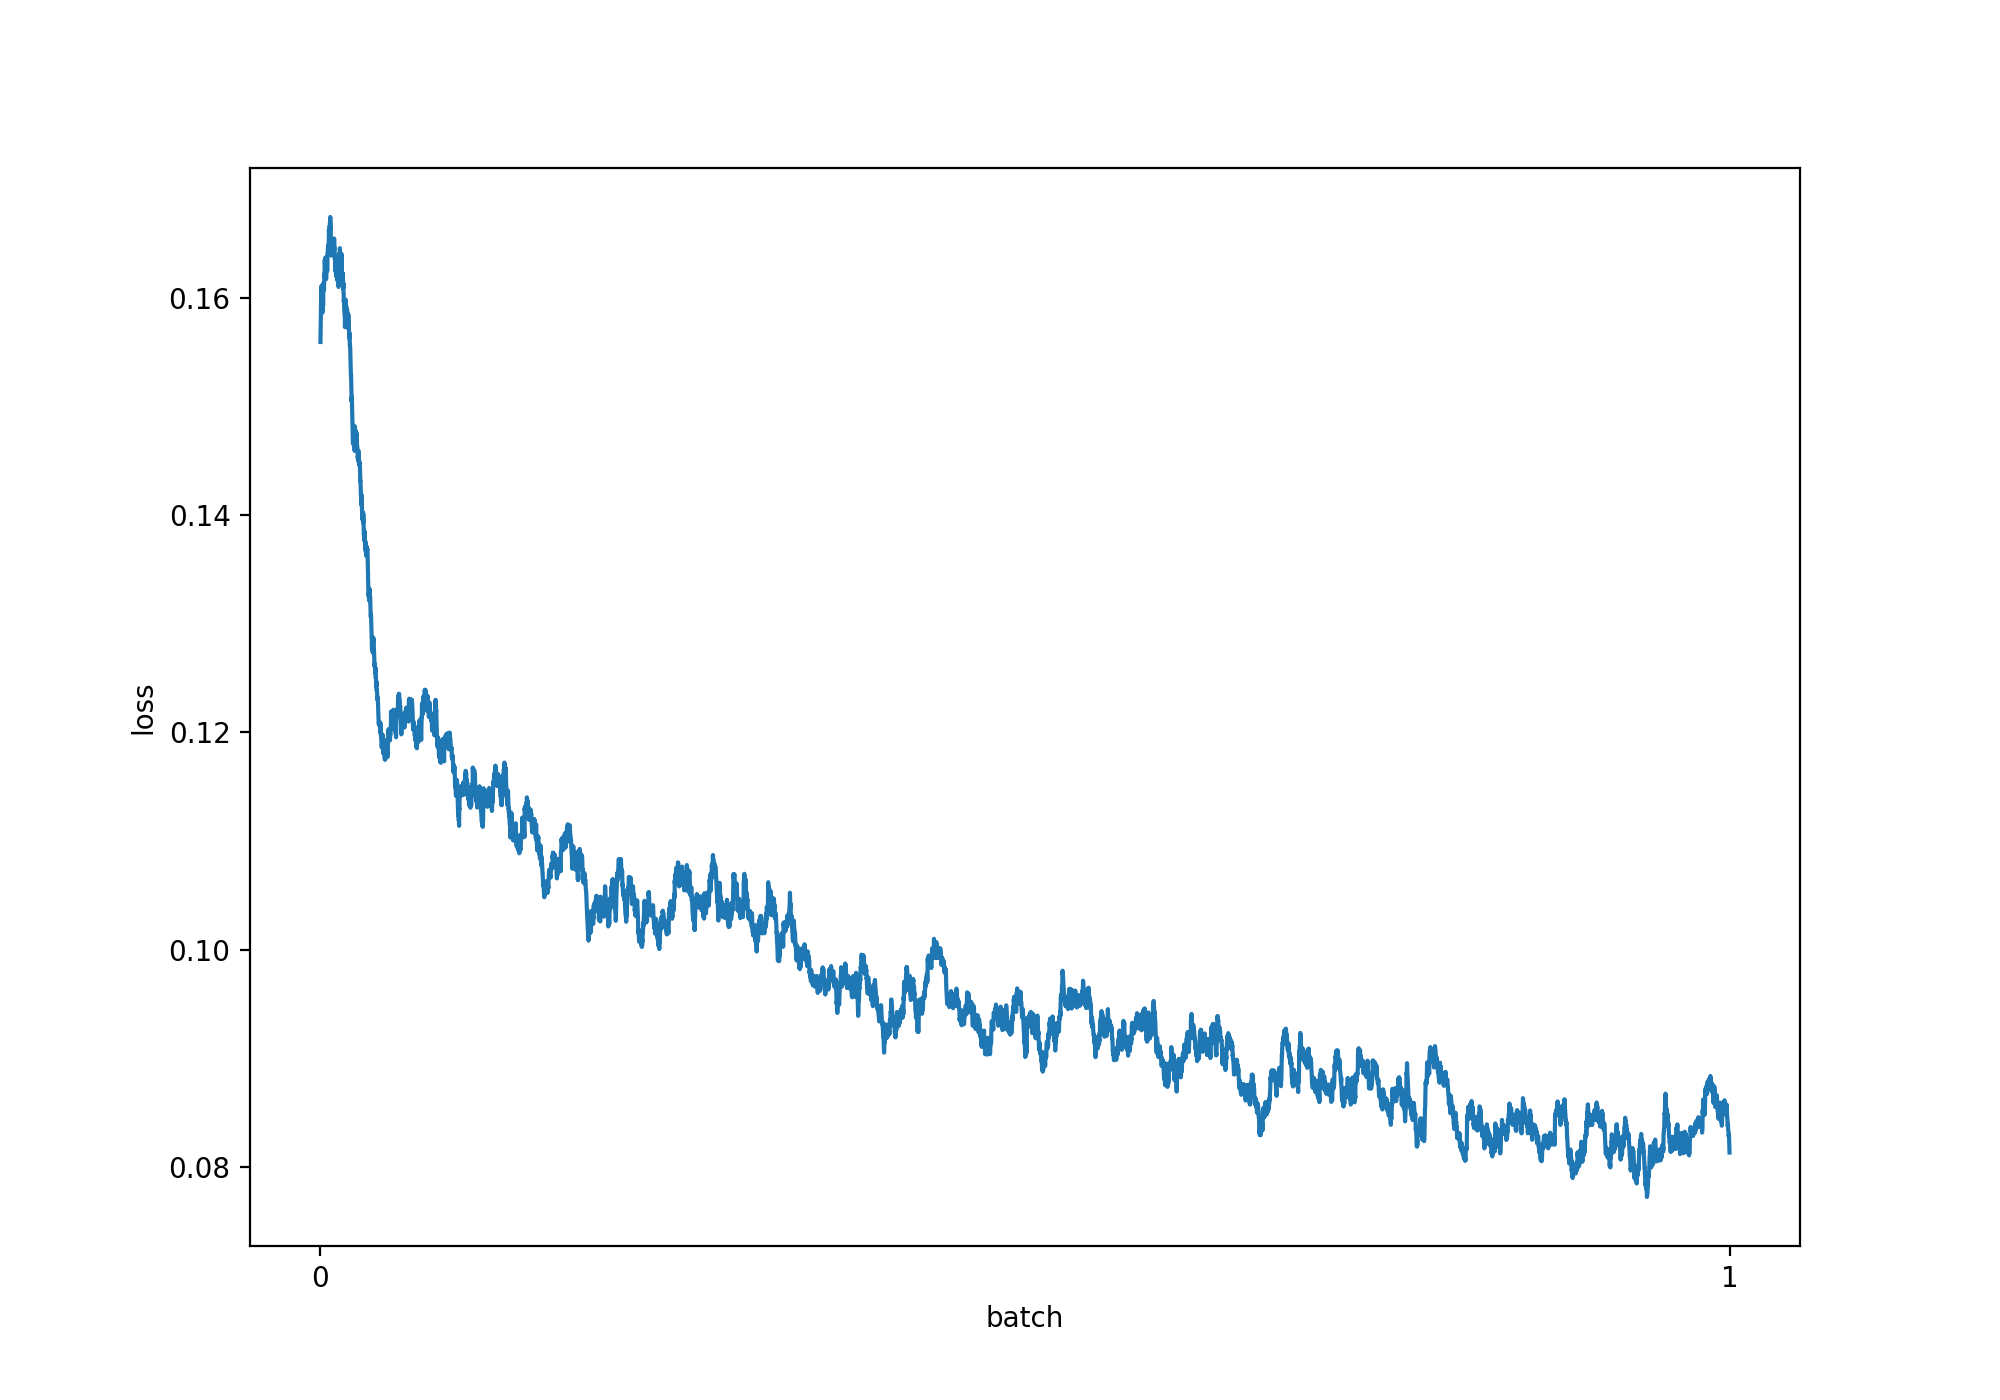

{'loss': 0.08134492379890305, 'val_loss': 0.08626892873559619}
0.08626892873559619


In [10]:
%matplotlib nbagg

num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=64
num_workers=12
num_epochs=1
model_name,version = 'Densenet121' , 'basic2_classifier'
model = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic2',num_split),map_location=torch.device(device)))
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,out_shape=(1,384,384))
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,out_shape=(1,384,384))
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [ ]:
%matplotlib nbagg

num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=64
num_workers=12
num_epochs=1
model_name,version = 'Densenet121' , 'basic2_classifier_pool'
model = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types),extra_pool=1)
model0 = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types),extra_pool=1)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic2_classifier',num_split),map_location=torch.device(device)))
#model.features=model0.features
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,out_shape=(1,384,384))
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,out_shape=(1,384,384))
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [14]:
model = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types),return_features=True)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic2_classifier',num_split),map_location=torch.device(device)))
_=model.to(device)
imagedataset_test=imagedataset_val
pred,features = model_run(model,imagedataset_test,do_apex=True,batch_size=96,num_workers=12)

pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features',num_split),'wb')
pickle.dump(features,pickle_file)
pickle_file.close()

In [11]:
model_name,version,num_split = 'Densenet161' , 'basic_more',0
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),return_features=True)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model.to(device)
transform_val=MyTransform(out_size=384)
imagedataset_test= ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir)
pred,features = model_run(model,imagedataset_test,do_apex=True,batch_size=96,num_workers=12)

pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features',num_split),'wb')
pickle.dump(features,pickle_file, protocol=4)
pickle_file.close()

/home/reina/anaconda3/envs/RSNA/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [ ]:
model_name,version,num_split = 'Densenet161' , 'basic_more',0
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),return_features=False)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model.to(device)
transform_val=MyTransform(out_size=384)
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
imagedataset_test= ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir)
model_evaluate(model,
                               DatasetCat([imagedataset_test,targets_dataset]),
                               64,
                               my_loss,
                               torch.tensor([1.,1.,1.,1.,1.,2.],device=device),None,
                               do_apex=False,
                               num_workers=12)

In [ ]:
my_loss(pred,
        torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float),
        torch.tensor([1.,1.,1.,1.,1.,2.]))

<IPython.core.display.Javascript object>


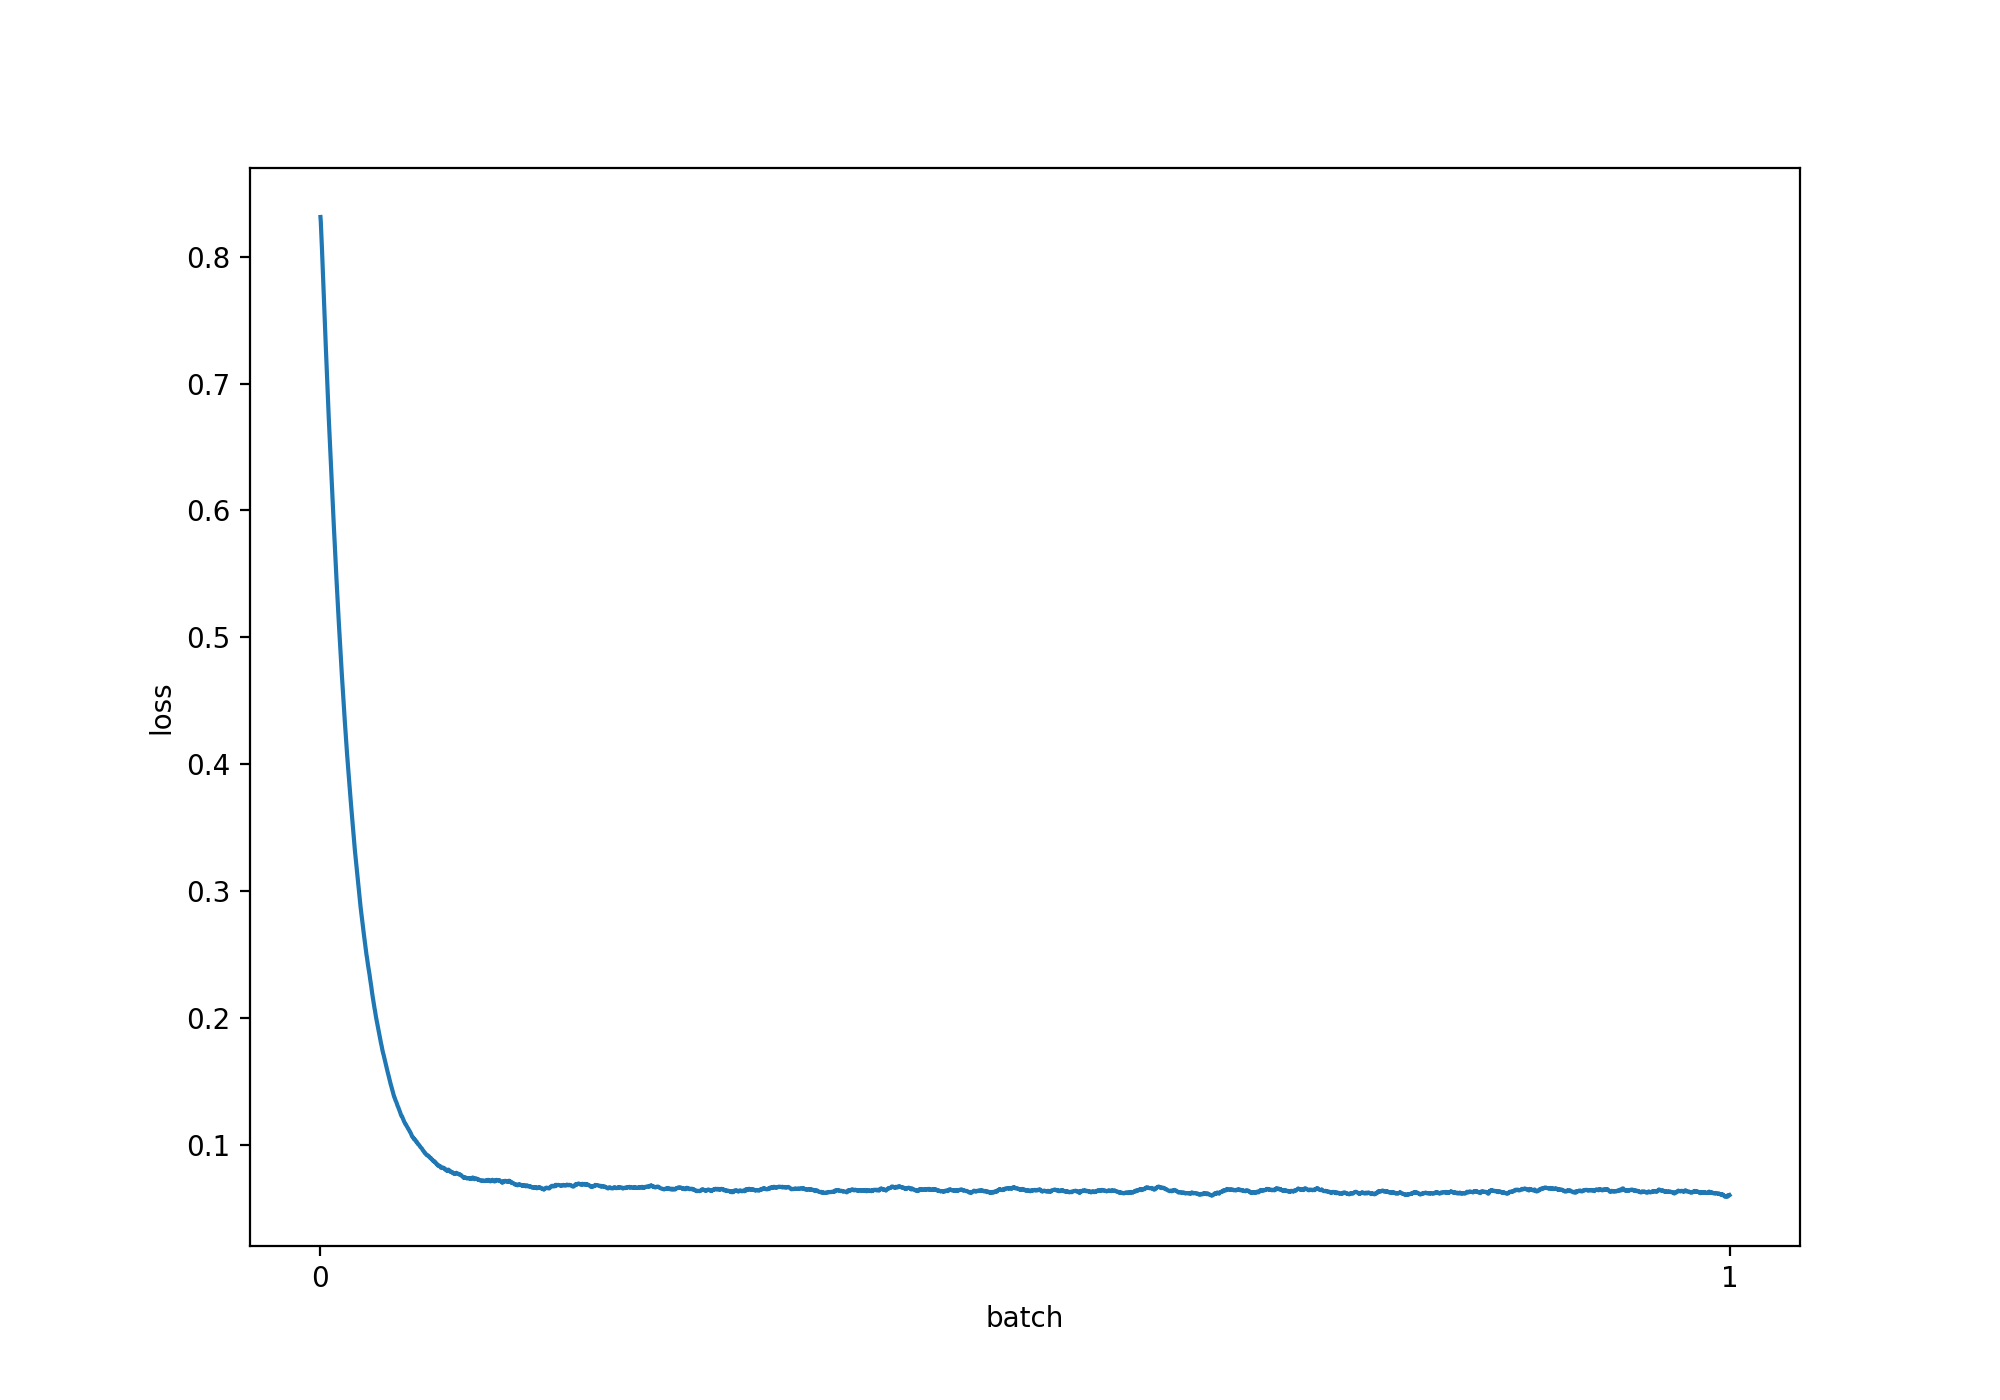

{'loss': 0.060136054586666154, 'val_loss': 0.06410701134522043}

0.06410701134522043


In [15]:
%matplotlib nbagg
num_neighbors=2
model_name,version,num_split = 'Densenet161' , 'basic_more',0
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=128
num_workers=1
num_epochs=1
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),
                   num_neighbors=num_neighbors,
                   num_features=model0.classifier.in_features,
                   intermidiate=128)
#classifier_layer=model0.classifier

version=version+'_neighbors{}in'.format(num_neighbors)
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
param_optimizer = model.parameters()
train_dataset=D.Subset(FeatursDataset(train_df,features,num_neighbors,'SeriesI','ImagePositionZ',hemorrhage_types),idx_train)
validate_dataset=D.Subset(FeatursDataset(train_df,features,num_neighbors,'SeriesI','ImagePositionZ',hemorrhage_types),idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

/home/reina/anaconda3/envs/RSNA/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


<IPython.core.display.Javascript object>


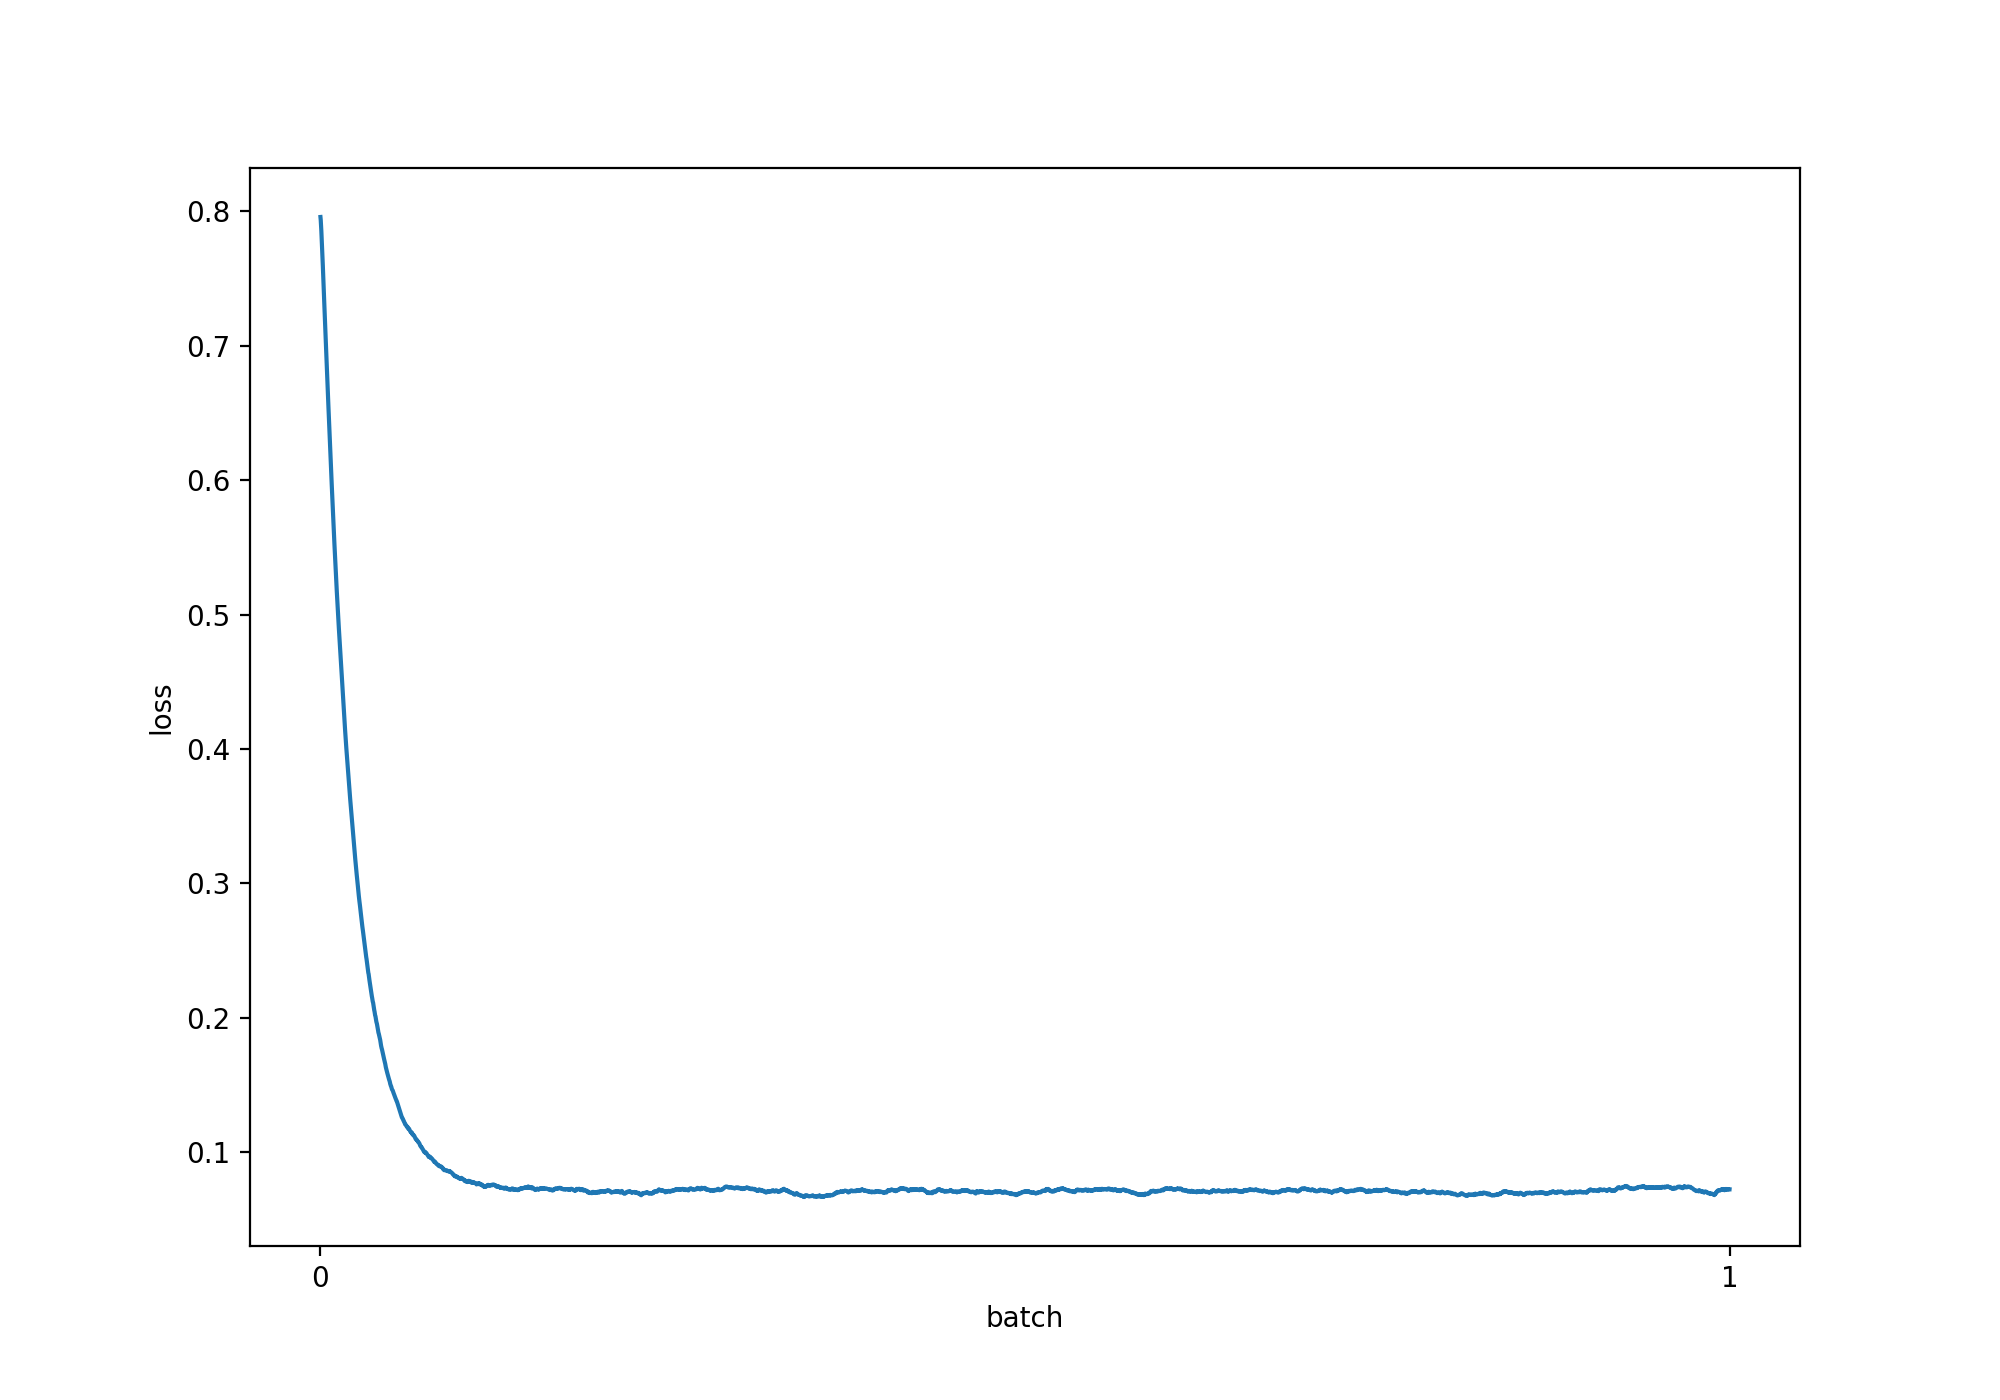

{'loss': 0.07251827245189185, 'val_loss': 0.0784266884799603}

0.0784266884799603


In [11]:
%matplotlib nbagg
num_neighbors=1
model_name,version,num_split = 'Densenet121' , 'basic2_classifier',0
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=128
num_workers=1
num_epochs=1
model0 = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),
                   num_neighbors=num_neighbors,
                   num_features=model0.classifier.in_features,
                   intermidiate=128)
#classifier_layer=model0.classifier

version=version+'_neighbors{}in'.format(num_neighbors)
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
param_optimizer = model.parameters()
train_dataset=D.Subset(FeatursDataset(train_df,features,num_neighbors,'SeriesI','ImagePositionZ',hemorrhage_types),idx_train)
validate_dataset=D.Subset(FeatursDataset(train_df,features,num_neighbors,'SeriesI','ImagePositionZ',hemorrhage_types),idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [9]:
%matplotlib nbagg
model_name,version,num_split = 'Densenet121' , 'basic2_classifier',0
#pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features',num_split),'rb')
#features=pickle.load(pickle_file, protocol=4)
#pickle_file.close()
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=1
num_epochs=1
model0 = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic2',num_split),map_location=torch.device(device)))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),classifier_layer=model0.classifier)


version=version+'_neighbors'
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
param_optimizer = model.parameters()
train_dataset=D.Subset(FeatursDataset(train_df,features,1,'SeriesI','ImagePositionZ',hemorrhage_types),idx_train)
validate_dataset=D.Subset(FeatursDataset(train_df,features,1,'SeriesI','ImagePositionZ',hemorrhage_types),idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [9]:
%matplotlib nbagg
model_name,version,num_split = 'Densenet121' , 'basic2_classifier',0
#pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features',num_split),'rb')
#features=pickle.load(pickle_file, protocol=4)
#pickle_file.close()
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=1
num_epochs=1
model0 = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic2',num_split),map_location=torch.device(device)))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),classifier_layer=model0.classifier)


version=version+'_neighbors'
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
param_optimizer = model.parameters()
train_dataset=D.Subset(FeatursDataset(train_df,features,1,'SeriesI','ImagePositionZ',hemorrhage_types),idx_train)
validate_dataset=D.Subset(FeatursDataset(train_df,features,1,'SeriesI','ImagePositionZ',hemorrhage_types),idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

/home/reina/anaconda3/envs/RSNA/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


<IPython.core.display.Javascript object>


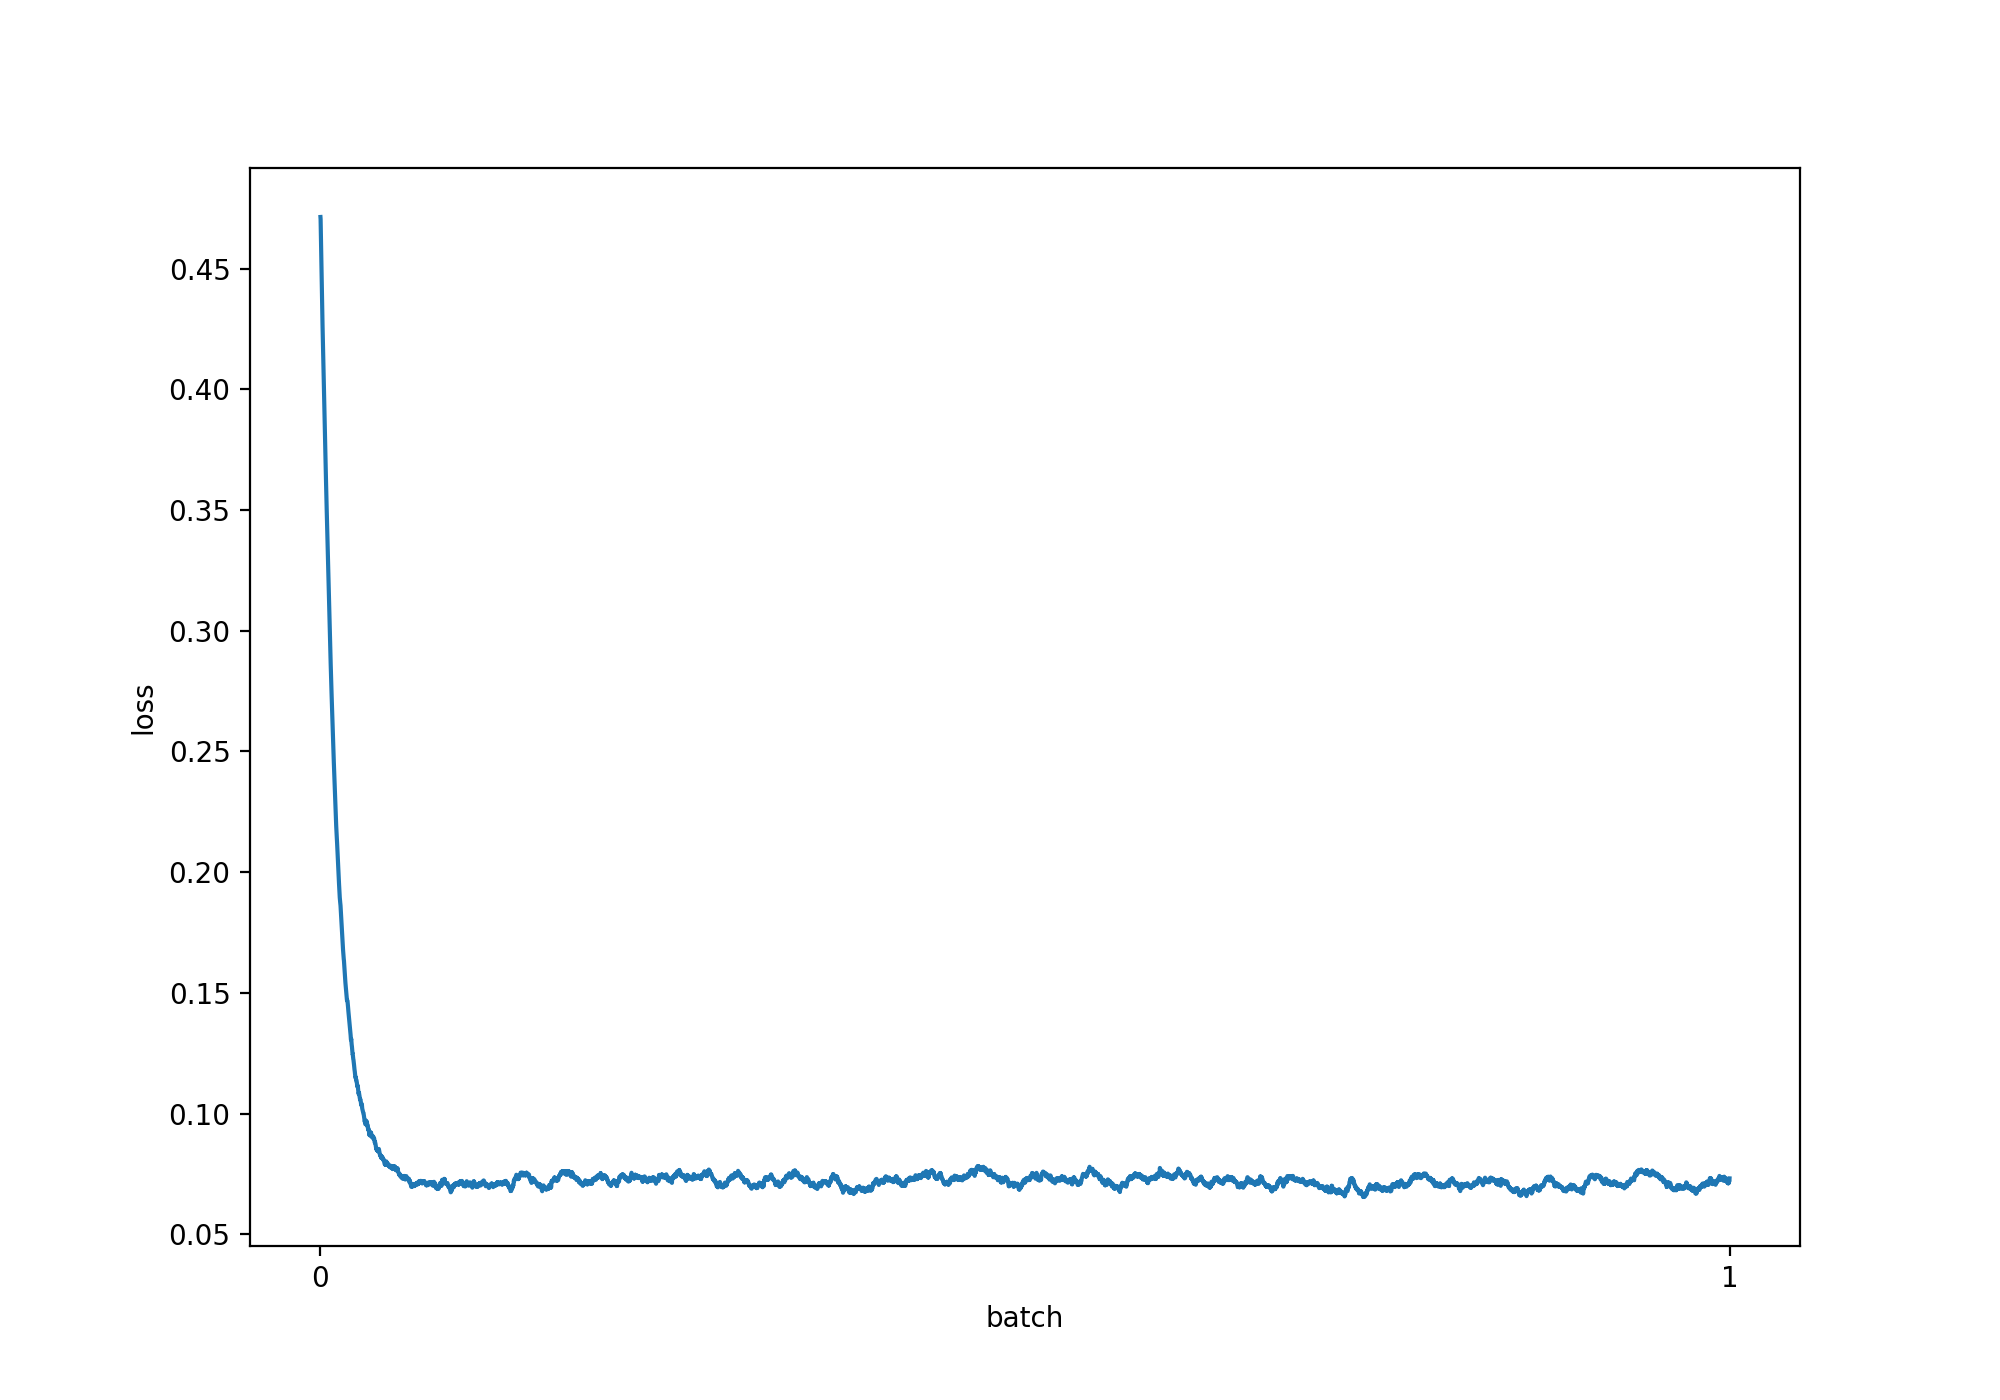

{'loss': 0.07317596894171052, 'val_loss': 0.0825874632865275}

0.0825874632865275


In [11]:
%matplotlib nbagg
num_neighbors=2
model_name,version,num_split = 'Densenet121' , 'basic2_classifier',0
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=1
num_epochs=1
model0 = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic2',num_split),map_location=torch.device(device)))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),num_neighbors=num_neighbors,classifier_layer=model0.classifier)


version=version+'_neighbors{}'.format(num_neighbors)
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
param_optimizer = model.parameters()
train_dataset=D.Subset(FeatursDataset(train_df,features,num_neighbors,'SeriesI','ImagePositionZ',hemorrhage_types),idx_train)
validate_dataset=D.Subset(FeatursDataset(train_df,features,num_neighbors,'SeriesI','ImagePositionZ',hemorrhage_types),idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [11]:
model_name,version,num_split = 'Densenet121' , 'basic2_classifier',0
model = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types),return_features=True)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model.to(device)
transform_val=MyTransform(out_size=384)
imagedataset_test=ImageDataset(test_df,transform=transform_val.random,base_path=test_images_dir)
pred,features = model_run(model,imagedataset_test,do_apex=True,batch_size=96,num_workers=12)
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'wb')
pickle.dump(features,pickle_file)
pickle_file.close()

/home/reina/anaconda3/envs/RSNA/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [12]:
num_neighbors=1
model_name,version,num_split = 'Densenet121' , 'basic2_classifier',0
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
model0 = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),classifier_layer=model0.classifier,num_neighbors=num_neighbors,intermidiate=128)
version=version+'_neighbors{}in'.format(num_neighbors)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=FeatursDataset(test_df,features,num_neighbors,'SeriesI','ImagePositionZ')
pred = model_run(model,test_dataset,do_apex=False,batch_size=512)

In [19]:
model_name,version,num_split = 'Densenet161' , 'basic_more',0
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),return_features=True)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model.to(device)
transform_val=MyTransform(out_size=384)
imagedataset_test=ImageDataset(test_df,transform=transform_val.random,base_path=test_images_dir)
pred,features = model_run(model,imagedataset_test,do_apex=True,batch_size=96,num_workers=12)
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'wb')
pickle.dump(features,pickle_file)
pickle_file.close()

In [17]:
num_neighbors=2
model_name,version,num_split = 'Densenet161' , 'basic_more',0
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),num_neighbors=num_neighbors,
                   classifier_layer=model0.classifier,intermidiate=128)
version=version+'_neighbors{}in'.format(num_neighbors)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=FeatursDataset(test_df,features,num_neighbors,'SeriesI','ImagePositionZ')
pred = model_run(model,test_dataset,do_apex=False,batch_size=512)

In [18]:
submission_df=get_submission(test_df,pred)
submission_df.head(12)
submission_df.shape
sub_num=11
submission_df.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])


,ID,Label
0,ID_000012eaf_any,6.556339e-04
1,ID_000012eaf_epidural,1.671564e-06
2,ID_000012eaf_intraparenchymal,3.973146e-05
3,ID_000012eaf_intraventricular,1.085250e-06
4,ID_000012eaf_subarachnoid,1.611753e-04
5,ID_000012eaf_subdural,2.686646e-04
6,ID_0000ca2f6_any,2.274479e-04
7,ID_0000ca2f6_epidural,1.742759e-07
8,ID_0000ca2f6_intraparenchymal,2.502893e-05
9,ID_0000ca2f6_intraventricular,1.446142e-07


(471270, 2)

<IPython.core.display.Javascript object>


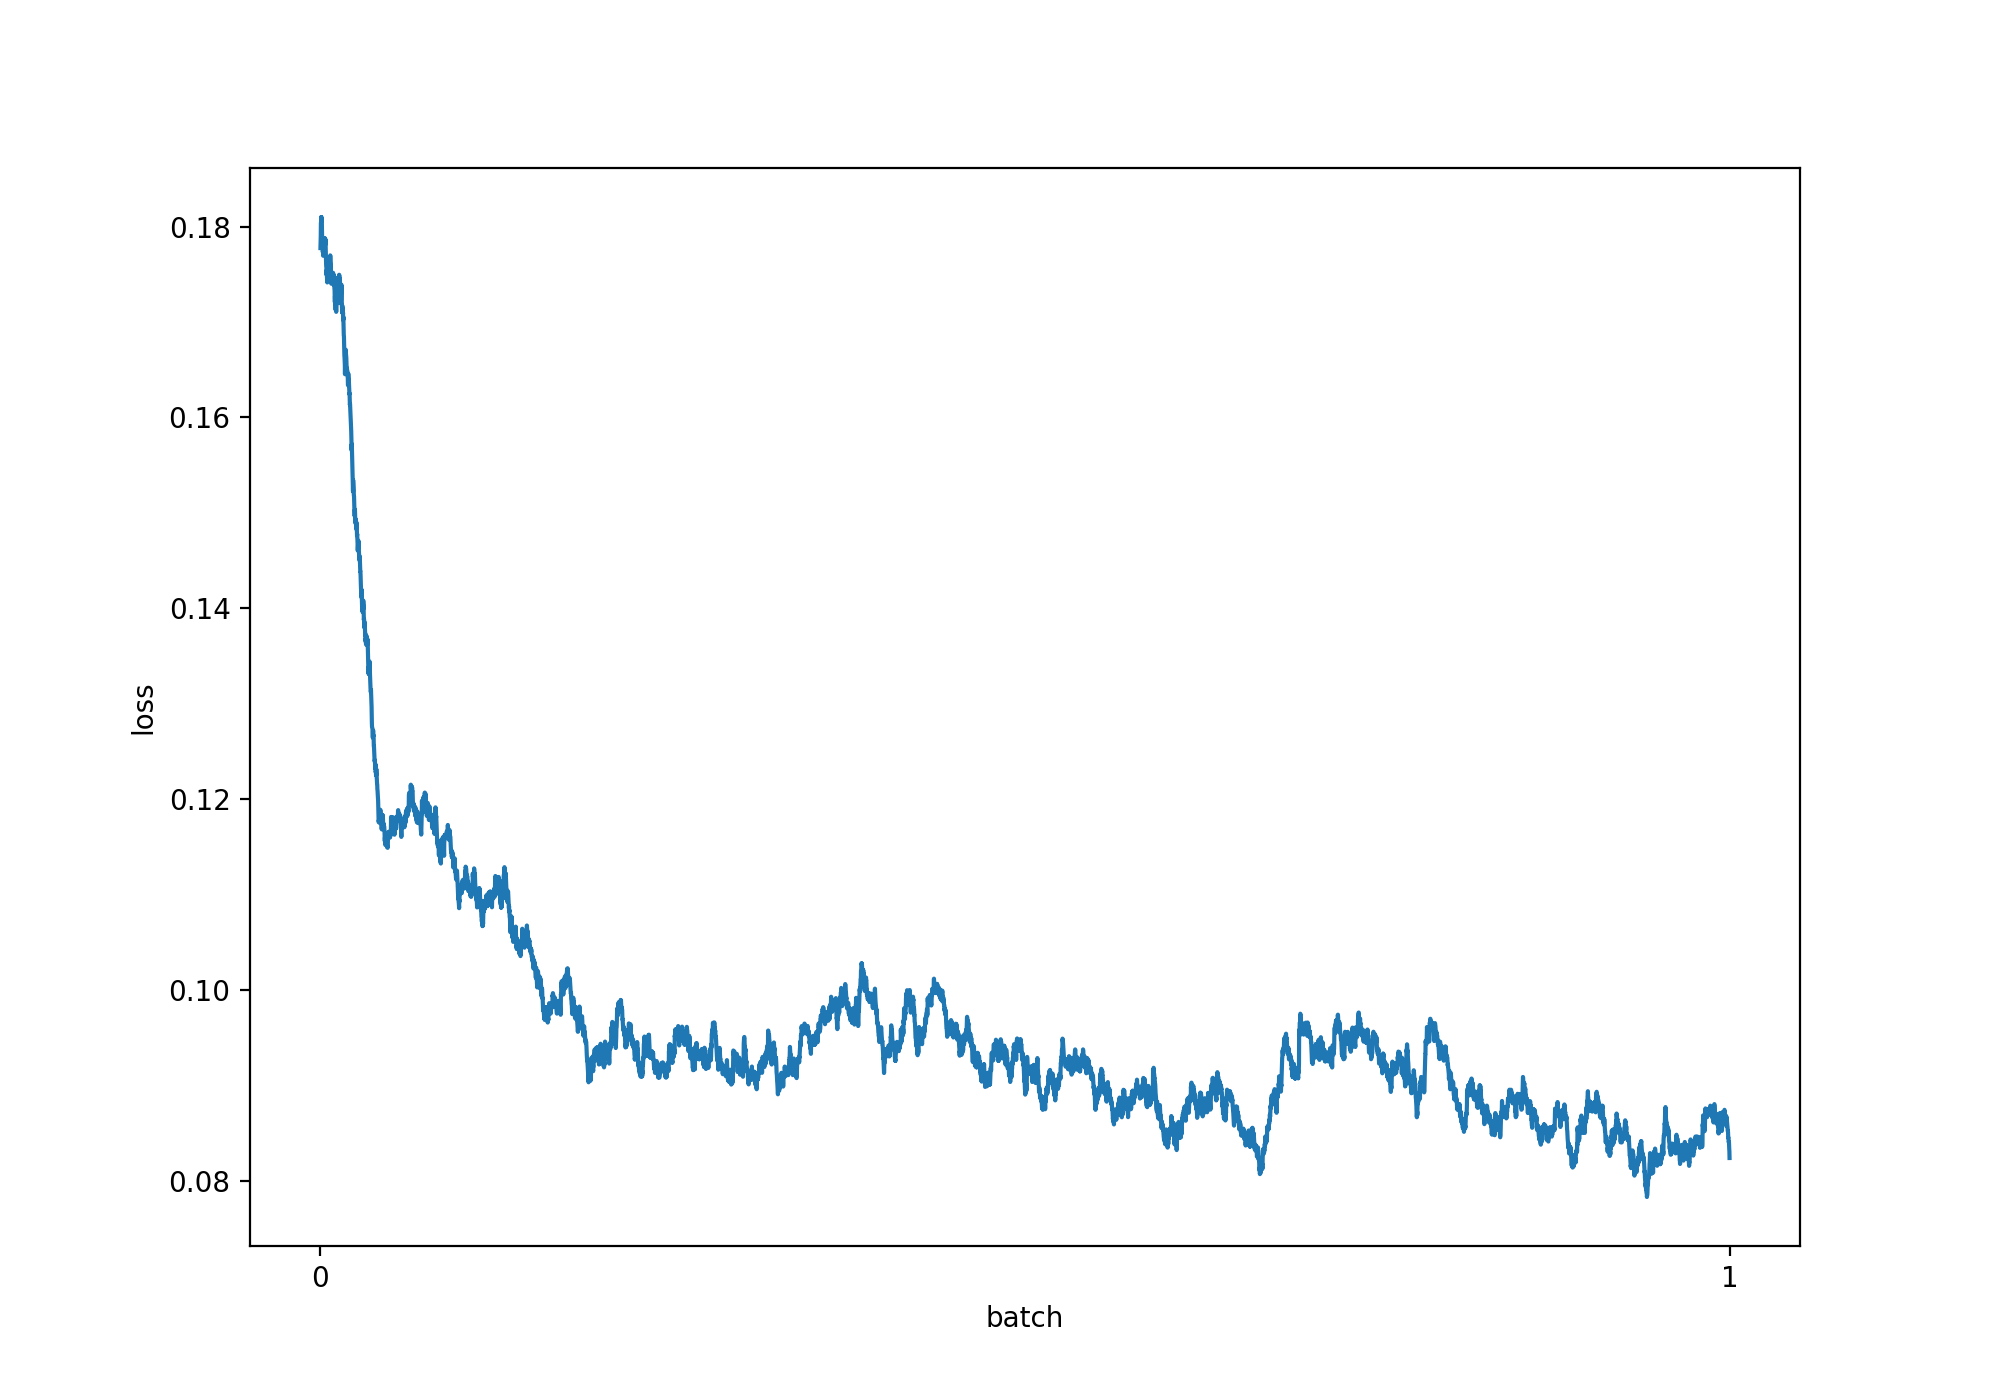

{'loss': 0.08240085913386809, 'val_loss': 0.08738561304434007}
0.08738561304434007


In [11]:
%matplotlib nbagg

num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=64
num_workers=12
num_epochs=1
model_name,version = 'Densenet121' , 'basic2_classifier1'
model = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic2',num_split),map_location=torch.device(device)))
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,out_shape=(1,384,384))
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,out_shape=(1,384,384))
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs*3,tau=1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

<IPython.core.display.Javascript object>


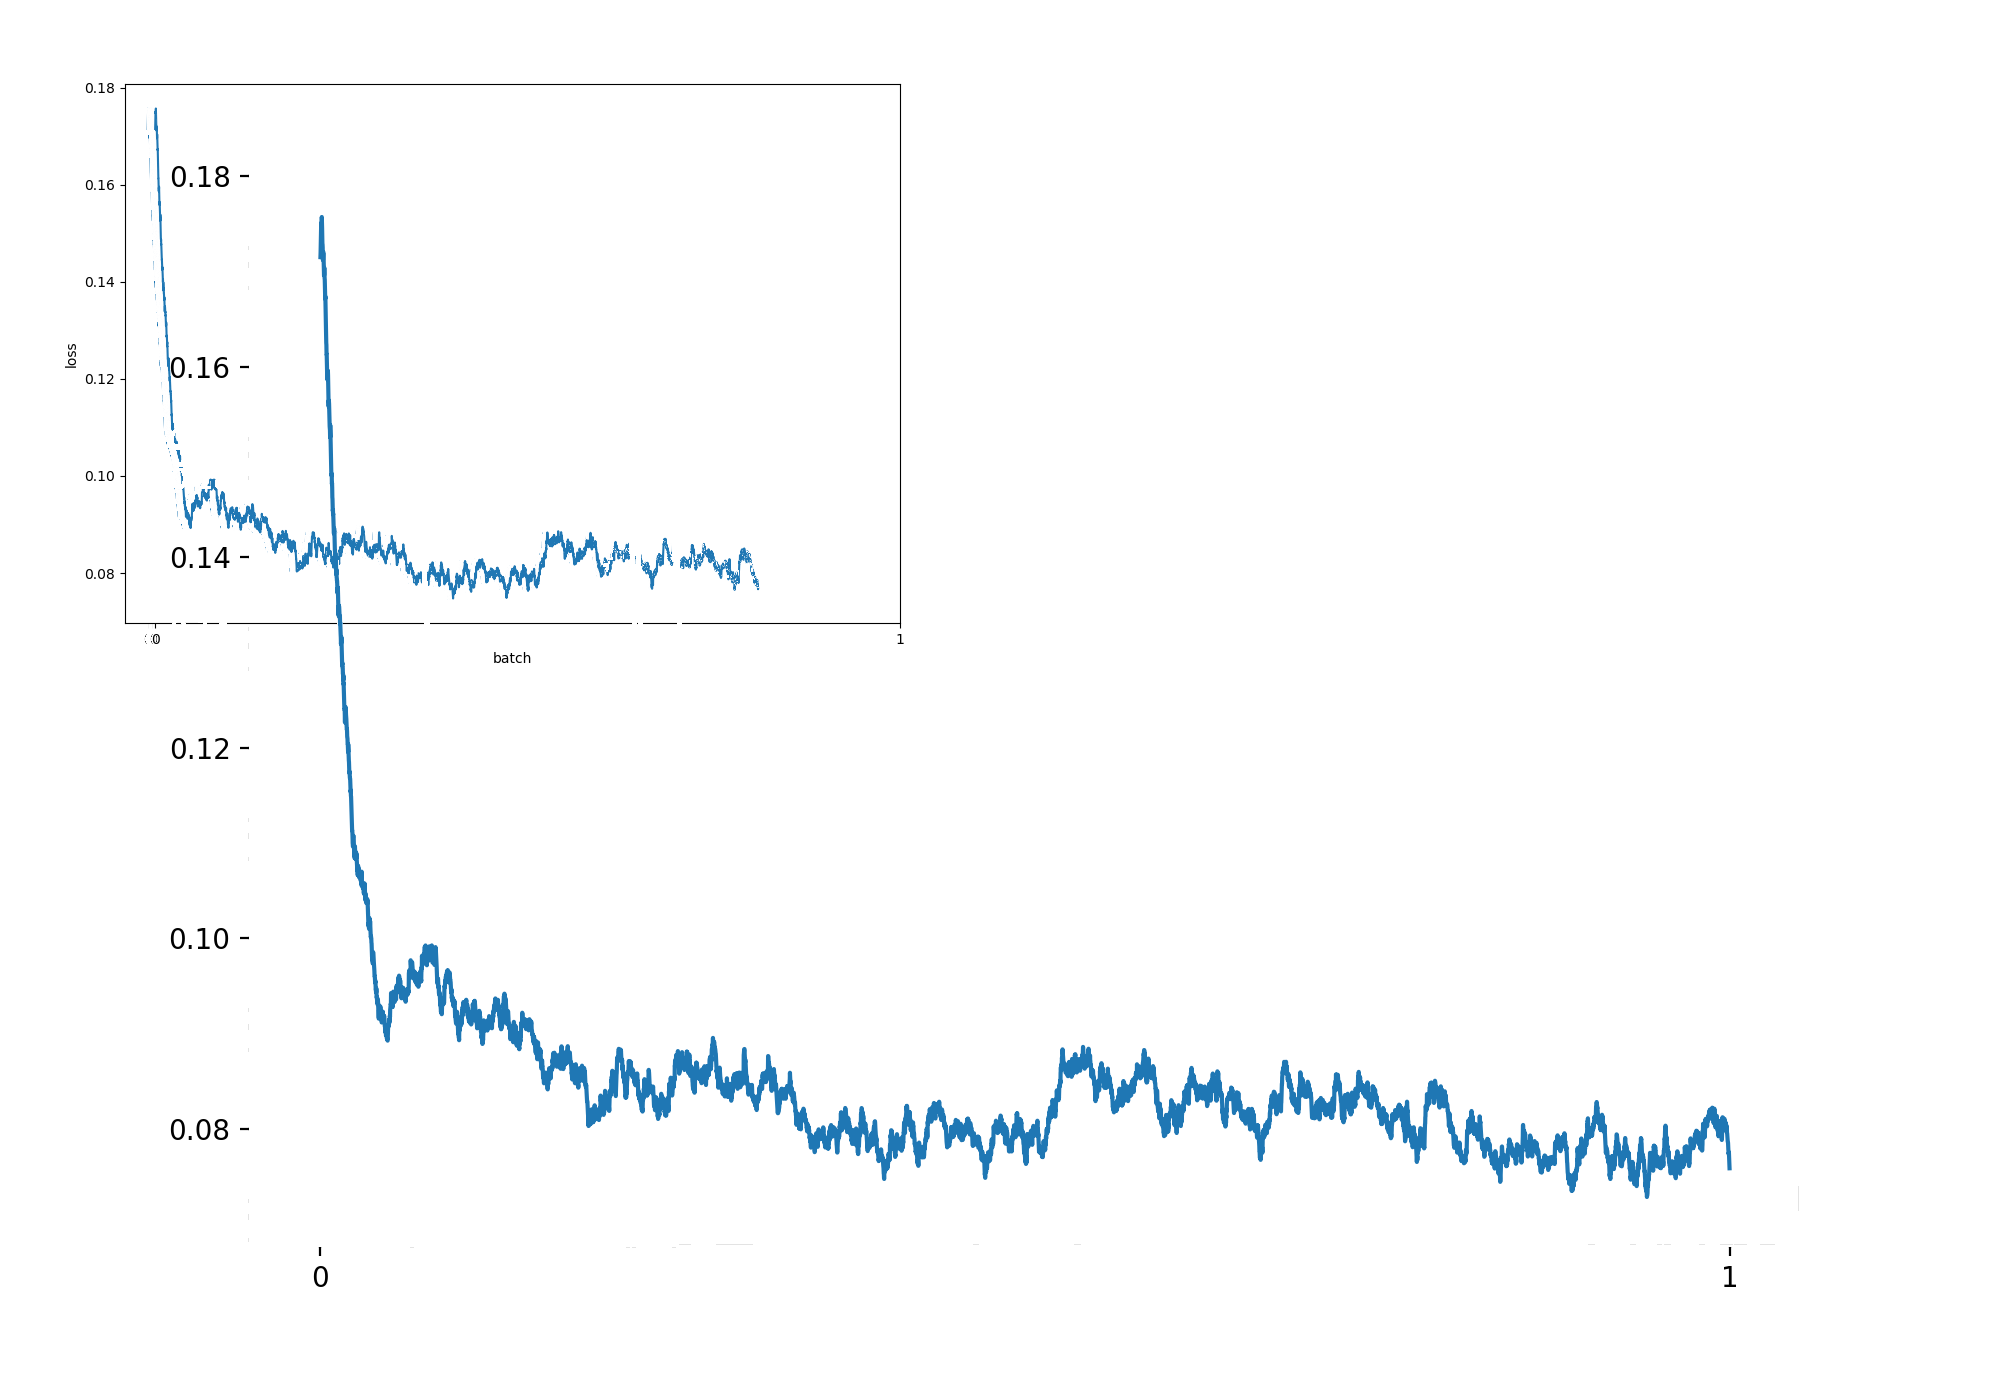

In [ ]:
%matplotlib nbagg

num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=12
num_epochs=1
model_name,version = 'Densenet121' , 'basic2_classifier2'
model = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic2',num_split),map_location=torch.device(device)))
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,out_shape=(1,384,384))
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,out_shape=(1,384,384))
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs*2,tau=1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [13]:
history

[{'loss': 0.07587585617427606, 'val_loss': 0.08701329026899401}]

In [8]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=64
num_workers=12
num_epochs=3
model_name,version = 'Densenet121' , 'basic1'
model = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir)
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.1,[20,1,1,1,1,0])
sample_ratio=1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//3,tau=1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=model.parameter_scheduler,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=sampling)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

/home/reina/anaconda3/envs/RSNA/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


{'loss': 0.5706150233517892, 'val_loss': 0.5105134567601469}


{'loss': 0.2153439511286734, 'val_loss': 0.14957282287623233}


{'loss': 0.1672099116428654, 'val_loss': 0.1318246226032425}

0.1318246226032425


In [11]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=64
num_workers=12
num_epochs=1
model_name,version = 'Densenet121' , 'basic1_classifier'
model = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic1',num_split),map_location=torch.device(device)))
_=model.to(device)
param_optimizer = list(model.named_parameters())
no_decay=['bias']
optimizer_grouped_parameters=[
    {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('classifier' in n))], 'lr':klr*1e-3,'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('classifier' in n)], 'lr':klr*1e-3, 'weight_decay': 0.0}
    ]
        
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,out_shape=(1,384,384))
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,out_shape=(1,384,384))
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=parameter_scheduler(model,num_epoch=num_epochs),
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

{'loss': 0.08525395505054703, 'val_loss': 0.10778535690619866}
0.10778535690619866


In [8]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=64
num_workers=12
num_epochs=2
model_name,version = 'Densenet121' , 'basic_classifier1'
model = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic',num_split),map_location=torch.device(device)))
_=model.to(device)
    
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,out_shape=(1,384,384))
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,out_shape=(1,384,384))
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs*3,tau=1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

/home/reina/anaconda3/envs/RSNA/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


{'loss': 0.08524218659078812, 'val_loss': 0.09112909327072773}


{'loss': 0.09099262477204285, 'val_loss': 0.08821471297976144}

0.08821471297976144


In [8]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=64
num_workers=12
num_epochs=3
model_name,version = 'Densenet121' , 'basic'
model = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)/7.0
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir)
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
idx_train = splits[num_split][0]
idx_validate = splits[num_split][1]
sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//3,tau=1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=model.parameter_scheduler,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=sampling)


got some error with pid {}.format(pid)
huston is the an empty picture e20bf3f8a
huston is the an empty picture 8da38f2e4
got some error with pid {}.format(pid)
huston is the an empty picture 6431af929


{'loss': 0.0738757445413808, 'val_loss': 0.04826765310945275}


huston is the an empty picture 470e639ae
got some error with pid {}.format(pid)
huston is the an empty picture 6431af929
huston is the an empty picture 0e21abf7a


{'loss': 0.03250126197022125, 'val_loss': 0.018087716315443533}


huston is the an empty picture d91d52bdc


{'loss': 0.025112670116517955, 'val_loss': 0.014796029577081213}

0.014796029577081213


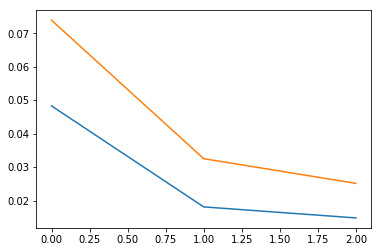

In [9]:
 plt.plot(np.array([[hist['val_loss'] for hist in history],[hist['loss'] for hist in history]]).transpose())

In [8]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=64
num_workers=12
num_epochs=1
model_name,version = 'Densenet121' , 'basic1_classifier'
model = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic',num_split),map_location=torch.device(device)))
_=model.to(device)
    
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir,out_shape=(1,384,384))
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir,out_shape=(1,384,384))
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
idx_train = splits[num_split][0]
idx_validate = splits[num_split][1]
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//1,tau=0)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None)


/home/reina/anaconda3/envs/RSNA/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


huston is the an empty picture d91d52bdc
got some error with pid {}.format(pid)
huston is the an empty picture e20bf3f8a
got some error with pid {}.format(pid)
huston is the an empty picture 6431af929
huston is the an empty picture 8da38f2e4
huston is the an empty picture 0e21abf7a
huston is the an empty picture 470e639ae


{'loss': 0.08385723255211137, 'val_loss': 0.08515054570595809}

0.08515054570595809


In [10]:
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))


In [9]:
0.08515054570595809/7

0.012164363672279728

In [15]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=64
num_workers=12
num_epochs=1
model_name,version = 'Densenet121' , 'basic1_classifier'
model1 = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
model1.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic',num_split),map_location=torch.device(device)))
model = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
model.features = model1.features
_=model.to(device)
param_optimizer = list(model.named_parameters())
no_decay=['bias']
optimizer_grouped_parameters=[
    {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('classifier' in n))], 'lr':klr*1e-3,'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('classifier' in n)], 'lr':klr*1e-3, 'weight_decay': 0.0}
    ]
    
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)/7.0
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir)
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
idx_train = splits[num_split][0]
idx_validate = splits[num_split][1]
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//1,tau=0)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None)


huston is the an empty picture 8da38f2e4
got some error with pid {}.format(pid)
huston is the an empty picture e20bf3f8a
huston is the an empty picture d91d52bdc
got some error with pid {}.format(pid)
huston is the an empty picture 6431af929
huston is the an empty picture 0e21abf7a
huston is the an empty picture 470e639ae


{'loss': 0.012869081265152378, 'val_loss': 0.012360272876939523}
0.012360272876939523


In [9]:
num_split=0
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=64
num_workers=12
num_epochs=1
model_name,version = 'Densenet121' , 'basic_classifier2'
model1 = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
model1.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic',num_split),map_location=torch.device(device)))
model = MyDenseNet(models.densenet121(pretrained=True),len(hemorrhage_types))
model.features = model1.features
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=384,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir)
transform_val=MyTransform(out_size=384)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
idx_train = splits[num_split][0]
idx_validate = splits[num_split][1]
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs*3,tau=1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None)


{'loss': 0.08751741203686533, 'val_loss': 0.08557805402268014}

0.08557805402268014


In [16]:
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [12]:
sample_submission=pd.read_csv(data_dir+'stage_1_sample_submission.csv')
sample_submission.head()
test_df=sample_submission.copy()
test_df['Sub_type'] = test_df['ID'].str.split("_", n = 3, expand = True)[2]
test_df['PatientID'] = test_df['ID'].str.split("_", n = 3, expand = True)[1]
test_df.head()

,ID,Label
0,ID_28fbab7eb_epidural,0.5
1,ID_28fbab7eb_intraparenchymal,0.5
2,ID_28fbab7eb_intraventricular,0.5
3,ID_28fbab7eb_subarachnoid,0.5
4,ID_28fbab7eb_subdural,0.5


,ID,Label,Sub_type,PatientID
0,ID_28fbab7eb_epidural,0.5,epidural,28fbab7eb
1,ID_28fbab7eb_intraparenchymal,0.5,intraparenchymal,28fbab7eb
2,ID_28fbab7eb_intraventricular,0.5,intraventricular,28fbab7eb
3,ID_28fbab7eb_subarachnoid,0.5,subarachnoid,28fbab7eb
4,ID_28fbab7eb_subdural,0.5,subdural,28fbab7eb


In [13]:
test_Id_df = pd.DataFrame(data={'PatientID':test_df.PatientID.unique()})
test_Id_df.head()

,PatientID
0,28fbab7eb
1,877923b8b
2,a591477cb
3,42217c898
4,a130c4d2f


In [14]:
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic1_classifier',num_split),map_location=torch.device(device)))
_=model.to(device)
imagedataset_test=ImageDataset(test_Id_df,transform=transform_val.random,base_path=test_images_dir)
pred = model_run(model,imagedataset_test,do_apex=True,batch_size=96,num_workers=12)

In [ ]:
def get_submission(test_df,pred):
    epidural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_epidural','Label':torch.sigmoid(pred[:,0])})
    intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraparenchymal','Label':torch.sigmoid(pred[:,1])})
    intraventricular_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraventricular','Label':torch.sigmoid(pred[:,2])})
    subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subarachnoid','Label':torch.sigmoid(pred[:,3])})
    subdural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subdural','Label':torch.sigmoid(pred[:,4])})
    any_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_any','Label':torch.sigmoid(pred[:,5])})
    return pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).reset_index(drop=True)

In [15]:
epidural_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_epidural','Label':torch.sigmoid(pred[:,0])})
intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_intraparenchymal','Label':torch.sigmoid(pred[:,1])})
intraventricular_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_intraventricular','Label':torch.sigmoid(pred[:,2])})
subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_subarachnoid','Label':torch.sigmoid(pred[:,3])})
subdural_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_subdural','Label':torch.sigmoid(pred[:,4])})
any_df=pd.DataFrame(data={'ID':'ID_'+test_Id_df.PatientID.values+'_any','Label':torch.sigmoid(pred[:,5])})


In [16]:
test_res_df = pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).reset_index(drop=True)
test_res_df.shape
test_res_df.sample(8)

(471270, 2)

,ID,Label
281642,ID_aa1cbfc28_subarachnoid,0.001057
187412,ID_bdd4bcf3f_intraventricular,0.001394
145584,ID_b0a36b472_intraparenchymal,0.000371
110649,ID_6866e8423_intraparenchymal,0.973645
340009,ID_24df0c26e_subdural,0.000358
404268,ID_ea25068d6_any,0.014337
459782,ID_a607c3de5_any,0.002083
158682,ID_4a4390fa1_intraventricular,0.000181


In [17]:
trd=test_res_df.sort_values('ID')
sample_submission[['ID','Label']]=trd.values[np.argsort(np.argsort(sample_submission.ID.values))]
sample_submission.head(10)

,ID,Label
0,ID_28fbab7eb_epidural,8.095930e-16
1,ID_28fbab7eb_intraparenchymal,1.321196e-05
2,ID_28fbab7eb_intraventricular,1.611992e-07
3,ID_28fbab7eb_subarachnoid,5.874842e-05
4,ID_28fbab7eb_subdural,1.186680e-04
5,ID_28fbab7eb_any,2.891032e-04
6,ID_877923b8b_epidural,2.111950e-16
7,ID_877923b8b_intraparenchymal,5.021150e-03
8,ID_877923b8b_intraventricular,8.349628e-05
9,ID_877923b8b_subarachnoid,1.115803e-02


In [23]:
sub_num=8

submission_df.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])
submission_df.head(10)

,ID,Label
0,ID_000012eaf_any,1.602680e-03
1,ID_000012eaf_epidural,4.284037e-07
2,ID_000012eaf_intraparenchymal,4.550510e-04
3,ID_000012eaf_intraventricular,5.390668e-05
4,ID_000012eaf_subarachnoid,4.141810e-04
5,ID_000012eaf_subdural,2.195521e-03
6,ID_0000ca2f6_any,4.155342e-04
7,ID_0000ca2f6_epidural,1.289171e-08
8,ID_0000ca2f6_intraparenchymal,1.003439e-04
9,ID_0000ca2f6_intraventricular,2.737013e-06


In [18]:
res=model_run(model,D.Subset(imagedataset_val,idx_validate),do_apex=True,batch_size=64,num_workers=12)

In [20]:
sigmoid_res=torch.sigmoid(res)

In [21]:
sigmoid_res

tensor([[4.1574e-06, 5.8291e-05, 1.9905e-07, 7.6621e-05, 1.7537e-04, 3.7703e-04],
        [2.9464e-03, 4.7603e-02, 2.5311e-03, 1.5948e-01, 3.0734e-02, 2.6493e-01],
        [5.0663e-16, 2.1330e-15, 1.1915e-17, 6.9331e-08, 7.7344e-08, 1.0738e-07],
        ...,
        [1.0902e-02, 2.1191e-01, 7.5187e-03, 5.0144e-02, 8.9933e-02, 3.5936e-01],
        [8.6822e-05, 8.0409e-04, 1.4159e-03, 1.0777e-02, 2.1998e-03, 2.2543e-02],
        [1.2906e-05, 2.0948e-05, 3.1561e-07, 2.7159e-04, 1.2400e-03, 1.2304e-03]])

In [23]:
t_val = train_df[hemorrhage_types].values[idx_validate]

In [52]:
t_dec = (sigmoid_res>0.5).numpy().astype(int)

In [53]:
((t_val==1) & (t_dec==1)).sum(0)/(t_val==1).sum(0)
((t_val==1) & (t_dec==0)).sum(0)/(t_val==1).sum(0)
((t_val==0) & (t_dec==1)).sum(0)/(t_val==0).sum(0)
((t_val==0) & (t_dec==0)).sum(0)/(t_val==0).sum(0)


array([0.05617978, 0.70373803, 0.80145175, 0.47830073, 0.57948596,
       0.78299845])

array([0.94382022, 0.29626197, 0.19854825, 0.52169927, 0.42051404,
       0.21700155])

array([0.00011908, 0.00412683, 0.00453086, 0.00511071, 0.01016617,
       0.01710941])

array([0.99988092, 0.99587317, 0.99546914, 0.99488929, 0.98983383,
       0.98289059])

In [35]:
((t_val==1) & (t_dec==0)).sum(0)/(t_val==1).sum(0)

array([0.98876404, 0.37751004, 0.27412468, 0.6198044 , 0.54807235,
       0.30108192])

In [51]:
model1.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic',num_split),map_location=torch.device(device)))
_=model1.to(device)
res1=model_run(model1,D.Subset(imagedataset_val,idx_validate),do_apex=True,batch_size=64,num_workers=12)
sigmoid_res1=torch.sigmoid(res1)


In [55]:
t_dec1 = (sigmoid_res1>0.3).numpy().astype(int)
((t_val==1) & (t_dec1==1)).sum(0)/(t_val==1).sum(0)
((t_val==1) & (t_dec1==0)).sum(0)/(t_val==1).sum(0)
((t_val==0) & (t_dec1==1)).sum(0)/(t_val==0).sum(0)
((t_val==0) & (t_dec1==0)).sum(0)/(t_val==0).sum(0)


array([0.82022472, 0.84213778, 0.89368061, 0.72188264, 0.82722513,
       0.93240598])

array([0.17977528, 0.15786222, 0.10631939, 0.27811736, 0.17277487,
       0.06759402])

array([0.00360205, 0.01630486, 0.01065905, 0.03029028, 0.04698889,
       0.09276833])

array([0.99639795, 0.98369514, 0.98934095, 0.96970972, 0.95301111,
       0.90723167])

In [61]:
my_loss((res+res1)/2,torch.tensor(t_val,dtype=torch.float),weights.to('cpu'))
my_loss(res,torch.tensor(t_val,dtype=torch.float),weights.to('cpu'))
my_loss(res1,torch.tensor(t_val,dtype=torch.float),weights.to('cpu'))

tensor(0.0123)

tensor(0.0124)

tensor(0.0148)

In [62]:
sigmoid_res12=torch.sigmoid((res+res1)/2)
t_dec12 = (sigmoid_res12>0.3).numpy().astype(int)
((t_val==1) & (t_dec12==1)).sum(0)/(t_val==1).sum(0)
((t_val==1) & (t_dec12==0)).sum(0)/(t_val==1).sum(0)
((t_val==0) & (t_dec12==1)).sum(0)/(t_val==0).sum(0)
((t_val==0) & (t_dec12==0)).sum(0)/(t_val==0).sum(0)

array([0.6741573 , 0.81340748, 0.88172502, 0.66748166, 0.77463113,
       0.90211231])

array([0.3258427 , 0.18659252, 0.11827498, 0.33251834, 0.22536887,
       0.09788769])

array([0.00120564, 0.01090105, 0.00855488, 0.01768491, 0.03065661,
       0.05626364])

array([0.99879436, 0.98909895, 0.99144512, 0.98231509, 0.96934339,
       0.94373636])

In [70]:
idx_validate4=idx_validate.repeat(4).reshape((idx_validate.shape[0],4)).reshape((1,-1)).squeeze()

In [71]:
res_tta=model_run(model,D.Subset(imagedataset,idx_validate4),do_apex=True,batch_size=96,num_workers=12)

In [77]:
rest=res_tta.reshape((idx_validate.shape[0],4,-1)).max(1)[0]

In [78]:
my_loss(rest,torch.tensor(t_val,dtype=torch.float),weights.to('cpu'))

tensor(0.0292)

In [74]:
my_loss(res_tta[:idx_validate.shape[0]],torch.tensor(t_val,dtype=torch.float),weights.to('cpu'))

tensor(0.2082)

In [123]:
0.084/0.124

0.6774193548387097